# Codigos para TFM: Cinthia Tavarez Mora

# Librerias

In [ ]:
#Paquetes a instalar
!pip install tweepy
!pip3 install twarc
!pip install panda
!pip install num2words
!pip install spacy

In [ ]:
!python -m spacy download es_core_news_sm #para lemmatizacion en español

In [ ]:
# Paquetes para tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re
import os
import gzip
import csv
import glob
import tweepy
import random
import time
#import num2words
import re
import spacy


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('wordnet')



# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Recoleccion de datos

In [ ]:
# PARA UNIFICAR LOS ARCHIVOS DEL 15 DE MARZO AL 31 DE MARZO

# Ruta de la carpeta que contiene los archivos TSV comprimidos
folder_path = '/content'

# Obtener la lista de archivos TSV comprimidos en la carpeta
file_list = glob.glob(folder_path + '/*.tsv.gz')

# Crear una lista para almacenar los DataFrames de cada archivo
dataframes = []

# Iterar sobre los archivos TSV comprimidos
for file_path in file_list:
    with gzip.open(file_path, 'rt') as f:
        # Leer el archivo TSV en un DataFrame utilizando pandas
        df = pd.read_csv(f, delimiter='\t')
        dataframes.append(df)

# Concatenar los DataFrames en uno solo
combined_df = pd.concat(dataframes)

# Guardar el DataFrame unificado en un archivo TSV
combined_df.to_csv('archivo_unificado.tsv', sep='\t', index=False)


## Extraccion de datos de Twitter

In [ ]:
# Conexion con la API de Twitter e hidratacion de tweets:
# ESTE TOMA EN CUENTA OTROS ASPECTOS A EXTRAER COMO URL, DATE, LOCALIZACION ENTRE OTROS


# Configura credenciales de API de Twitter
consumer_key = "9d5DWSbGvAxrk8UYp9L9SK0nd"
consumer_secret = "jipLIx5lPy63CEGlQgrTYPM36Ox3sjrrK3N30RqCj1rIpyKu19"
access_token = "1528355012971319298-wHBskBWF4QlQ4j2zMqaZeWSNFElKgq"
access_token_secret = "jqVS5AZLCW1b5UWEfloNUiVIRDF1rQQX2DJ8M7oCamtmO"

# Autenticación con API de Twitter
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
# Crear un objeto API
api = tweepy.API(auth)

# Archivos de entrada y salida
input_file = 'archivo_unificado.tsv'
output_file = 'tweets_hydrated1.tsv'

# Número máximo de tweets a revisar
max_tweets = 1000

# Palabra clave para filtrar los tweets
keywords = ["vacunan","antivacuna","trombos","coagulos","imanes","chip","ADN","ARN","manipulan"]

# Leer el archivo de entrada
df_input = pd.read_csv(input_file, sep='\t')


# Cargar el DataFrame existente desde un archivo o variable
with open("/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv") as fd:
    df_viejo = pd.read_csv(fd, delimiter="\t")

# Subset con id unicos del archivo viejo
existing_ids = df_viejo['User ID']

# Filtra los nuevos IDs para evitar duplicados
# Filtrar los IDs de los tweets que cumplen las condiciones requeridas
filtered_tweet_ids =df_input[(df_input['lang'] == 'es')]['tweet_id']
filtered_tweet_ids = [tweet_id for tweet_id in filtered_tweet_ids if tweet_id not in existing_ids]

# Obtener los IDs de los tweets únicos del archivo de entrada
tweet_ids = filtered_tweet_ids

# Seleccionar aleatoriamente los IDs de los tweets a revisar
tweet_ids_sample = random.sample(tweet_ids, min(max_tweets, len(tweet_ids)))


# Lista para almacenar los datos de los tweets
tweet_data = []

# Iterar sobre los IDs de los tweets seleccionados aleatoriamente
for tweet_id in tweet_ids_sample:
    try:
        # Obtener el tweet completo a partir del ID
        tweet = api.get_status(tweet_id, tweet_mode='extended')

        # Verificar si el tweet contiene alguna de las palabras clave
        if any(keyword in tweet.full_text for keyword in keywords):
            # Obtener la información del tweet
            id_user = tweet.user.id_str
            name_user = tweet.user.screen_name
            location = tweet.user.location
            text = tweet.full_text
            url = tweet.entities.get('urls')[0]['expanded_url'] if tweet.entities.get('urls') else None,
            date = tweet.created_at.date()
            hashtags = [tag['text'] for tag in tweet.entities.get('hashtags')]

            # Agregar los datos del tweet a la lista
            tweet_data.append([tweet_id, id_user, name_user, location, text, url, date, hashtags])

    except tweepy.TweepyException as e:
        # Manejar errores en caso de que el tweet no pueda ser encontrado o haya algún problema con la API
        print(f"Error al obtener el tweet con ID {tweet_id}: {e}")

# Crear un DataFrame con los datos de los tweets
columns = ['Tweet ID', 'User ID', 'User Name', 'Location', 'Text', 'URL', 'Date', 'Hashtags']
df_output = pd.DataFrame(tweet_data, columns=columns)



In [ ]:
### AQUI hacemos un proceso quizas poco eficiente para guardar los nuevos registros NO DUPLICADOS
import os

# Cargar el DataFrame existente desde un archivo o variable
with open("/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv") as fd:
    df_viejo = pd.read_csv(fd, delimiter="\t")

# Subset con id unicos del archivo viejo
existing_ids = df_viejo['User ID']

# Filtra los nuevos IDs para evitar duplicados
new_ids = df_output[~df_output['User ID'].isin(existing_ids)]

# Concatenar los DataFrames existente y nuevo
df_combina = pd.concat([df_viejo, new_ids], ignore_index=True)

# PARA GUARDAR EL NUEVO ARCHIVO

# 1. Creamos la ruta y el nombre de archivo que deseas verificar y eliminar si existe
file_path = '/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv'

# Verifica si el archivo existe en la ruta especificada
if os.path.exists(file_path):
    # Elimina el archivo si existe
    os.remove(file_path)
    print("El archivo existente ha sido eliminado.")
else:
    print("El archivo no existe.")

# NUEVA VEZ le decimos la ruta y el nombre de archivo para guardar el DataFrame combinado en formato TSV
output_file = '/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv'

# Guarda el DataFrame combinado en el archivo TSV
df_combina.to_csv(output_file, sep='\t', index=False)

print("Proceso exitoso")

El archivo existente ha sido eliminado.
Proceso exitoso


In [ ]:
#ALTERNATIVA PARA DEJARLO CORRER SOLO: CREAR UN PROCESO AUTOMATICO PARA QUE CONSULTE Y SUME MAS TUITS AL ARCHIVO FINAL
from time import sleep
 # Número de veces que se ejecutará el código interno
num_ejecuciones_interno =2

# Intervalo de tiempo en segundos (15 minutos = 900 segundos)
intervalo_tiempo = 900

# Ciclo externo para repetir el proceso 10 veces
for i in range(num_ejecuciones_interno):
    # Aquí va tu código

    # Configura tus credenciales de API de Twitter
    consumer_key = "9d5DWSbGvAxrk8UYp9L9SK0nd"
    consumer_secret = "jipLIx5lPy63CEGlQgrTYPM36Ox3sjrrK3N30RqCj1rIpyKu19"
    access_token = "1528355012971319298-wHBskBWF4QlQ4j2zMqaZeWSNFElKgq"
    access_token_secret = "jqVS5AZLCW1b5UWEfloNUiVIRDF1rQQX2DJ8M7oCamtmO"

    # Autenticación con API de Twitter
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    # Crear un objeto API
    api = tweepy.API(auth)

    # Archivos de entrada y salida
    input_file = 'archivo_unificado.tsv'
    output_file = 'tweets_hydrated1.tsv'

    # Número máximo de tweets a revisar
    max_tweets = 1000

    # Palabra clave para filtrar los tweets
    keywords = ["vacunar","antivacuna","trombos","coagulos","imanes","chip","ADN","ARN","manipulan","vacunas"]

    # Leer el archivo de entrada
    df_input = pd.read_csv(input_file, sep='\t')


    # Cargar el DataFrame existente desde un archivo o variable
    with open("/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv") as fd:
        df_viejo = pd.read_csv(fd, delimiter="\t")

    # Subset con id unicos del archivo viejo
    existing_ids = df_viejo['User ID']

    # Filtra los nuevos IDs para evitar duplicados
    # Filtrar los IDs de los tweets que cumplen las condiciones requeridas
    filtered_tweet_ids =df_input[(df_input['lang'] == 'es')]['tweet_id']
    filtered_tweet_ids = [tweet_id for tweet_id in filtered_tweet_ids if tweet_id not in existing_ids]

    # Obtener los IDs de los tweets únicos del archivo de entrada
    tweet_ids = filtered_tweet_ids

    # Seleccionar aleatoriamente los IDs de los tweets a revisar
    tweet_ids_sample = random.sample(tweet_ids, min(max_tweets, len(tweet_ids)))


    # Lista para almacenar los datos de los tweets
    tweet_data = []

    # Iterar sobre los IDs de los tweets seleccionados aleatoriamente
    for tweet_id in tweet_ids_sample:
        try:
            # Obtener el tweet completo a partir del ID
            tweet = api.get_status(tweet_id, tweet_mode='extended')

            # Verificar si el tweet contiene alguna de las palabras clave
            if any(keyword in tweet.full_text for keyword in keywords):
                # Obtener la información del tweet
                id_user = tweet.user.id_str
                name_user = tweet.user.screen_name
                location = tweet.user.location
                text = tweet.full_text
                url = tweet.entities.get('urls')[0]['expanded_url'] if tweet.entities.get('urls') else None,
                date = tweet.created_at.date()
                hashtags = [tag['text'] for tag in tweet.entities.get('hashtags')]

                # Agregar los datos del tweet a la lista
                tweet_data.append([tweet_id, id_user, name_user, location, text, url, date, hashtags])

        except tweepy.TweepyException as e:
            # Manejar errores en caso de que el tweet no pueda ser encontrado o haya algún problema con la API
            print(f"Error al obtener el tweet con ID {tweet_id}: {e}")

    # Crear un DataFrame con los datos de los tweets
    columns = ['Tweet ID', 'User ID', 'User Name', 'Location', 'Text', 'URL', 'Date', 'Hashtags']
    df_output = pd.DataFrame(tweet_data, columns=columns)


    # Guardar el DataFrame en un archivo TSV
    #df_output.to_csv(output_file, sep='\t', index=False)
    # Cargar el DataFrame existente desde un archivo o variable
    with open("/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv") as fd:
        df_viejo = pd.read_csv(fd, delimiter="\t")

    # Subset con id unicos del archivo viejo
    existing_ids = df_viejo['User ID']

    # Filtra los nuevos IDs para evitar duplicados
    new_ids = df_output[~df_output['User ID'].isin(existing_ids)]

    # Concatenar los DataFrames existente y nuevo
    df_combina = pd.concat([df_viejo, new_ids], ignore_index=True)

    # PARA GUARDAR EL NUEVO ARCHIVO

    # 1. Creamos la ruta y el nombre de archivo que deseas verificar y eliminar si existe
    file_path = '/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv'

    # Verifica si el archivo existe en la ruta especificada
    if os.path.exists(file_path):
        # Elimina el archivo si existe
        os.remove(file_path)
        print("El archivo existente ha sido eliminado.")
    else:
        print("El archivo no existe.")

    # NUEVA VEZ le decimos la ruta y el nombre de archivo para guardar el DataFrame combinado en formato TSV
    output_file = '/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv'

    # Guarda el DataFrame combinado en el archivo TSV
    df_combina.to_csv(output_file, sep='\t', index=False)


      # Ciclo interno para esperar 15 minutos antes de la siguiente ejecución
    for j in range(intervalo_tiempo):
        print(f"Tiempo restante: {intervalo_tiempo - j} segundos")
        time.sleep(1)


In [ ]:
# PARA VISUALIZAR EL ARCHIVO UNIFICADO COMO DATAFRAME DE PANDA
file_path = '/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv'
df = pd.read_csv(file_path, sep='\t')
pd.DataFrame(df)

In [ ]:
# PARA CONTAR LOS TUIT DEL ARCHIVO UNIFICADO

input_file = '/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv'

# Contador de IDs obtenidos
count = 0

# Abrir el archivo de entrada para lectura
with open(input_file) as f_input:
    reader = csv.reader(f_input, delimiter='\t')

    # Ignorar la primera línea (encabezados)
    next(reader)

    # Iterar sobre las filas del archivo
    for row in reader:
        # Incrementar el contador por cada fila (ID)
        count += 1

print("Total de IDs obtenidos:", count)


# Generar data final

In [ ]:
# PARA VER SI HAY REGISTROS DUPLICADOS
file_path = '/content/drive/MyDrive/Colab Notebooks/tuits/combined_file.tsv'
df = pd.read_csv(file_path, sep='\t')

df1 = df[df.duplicated(keep=False)]
df1 = df1.groupby(df1.columns.tolist()).apply(lambda x: x.index.tolist()).values.tolist()
print (df1)

[[2592, 2737], [2539, 2684], [4122, 4282], [4179, 4339], [3347, 3483], [3337, 3473], [2899, 4040], [3315, 3451], [3358, 3494], [4258, 4418], [3725, 3866], [3778, 3919], [3279, 3415], [2562, 2707], [3738, 3879], [4263, 4423, 4896], [2571, 2716], [1420, 3110], [4190, 4350], [4240, 4400], [2519, 2664], [114, 1597], [3280, 3416], [4158, 4318], [3687, 3828], [3708, 3849], [3272, 3408], [2522, 2667], [3259, 3395], [3717, 3858], [4143, 4303], [4225, 4385], [4142, 4302], [3322, 3458], [2624, 2769], [4187, 4347], [3335, 3471], [3275, 3411], [2578, 2723], [647, 2842, 3606], [655, 5150], [4262, 4422], [2540, 2685], [3343, 3479], [3237, 5366], [3682, 3823], [1275, 1603], [3722, 3863], [4130, 4290], [3698, 3839], [2478, 3644], [2630, 2775], [3706, 3847], [3794, 3935], [2538, 2683], [2529, 2674], [4249, 4409], [546, 4483], [2587, 2732], [4253, 4413], [3783, 3924], [2560, 2705], [2557, 2702], [3291, 3427], [4160, 4320], [2155, 2414], [4224, 4384], [2614, 2759], [2582, 2727], [2549, 2694], [2537, 2682

In [ ]:
# PARA ELIMINAR DUPLICADOS
df = df.drop_duplicates(subset=['User ID'])

print("Total registros sin duplicados",len(df))

Total registros sin duplicados 11787


# Pre-procesamiento de datos

In [ ]:
# Cargar el DataFrame existente desde un archivo o variable para poder manipularlo

tweets=df
# Convertir en string la columna texto
tweets.Text=tweets.Text.astype(str)

## Limpieza

In [ ]:
# Esta función limpia y tokeniza el texto en palabras individuales.
# El orden en el que se va limpiando el texto no es arbitrario.
# El listado de signos de puntuación se ha obtenido de: print(string.punctuation) y re.escape(string.punctuation)
# Tomada de :https://www.cienciadedatos.net/documentos/py25-text-mining-python

import re

def limpiar_tokenizar(texto):
  # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de '@' y '#'
    nuevo_texto = re.sub(r'\b@\w+\b', '', nuevo_texto)
    #nuevo_texto = re.sub(r'\#\w+', '', nuevo_texto)  # Eliminación de palabras con '#'
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Eliminación de signos de puntuación y caracteres no alfanuméricos
    regex = '[^\w\s]'
    nuevo_texto = re.sub(regex, '', nuevo_texto)
    # Eliminación de números que no están seguidos de palabras clave
    #nuevo_texto = re.sub(r"\b(?<!\w)(\d+)\b(?!(?:\s+(?:edad|años|dosis|vacunas|personas|pacientes|inscriptos|casos|vacunados))\b)", '', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split()
    # Reemplazar guiones bajos entre palabras por espacios
    nuevo_texto = [item.replace('_', '') for item in nuevo_texto]
    # Eliminación de tokens con una longitud < 2, palabras que comienzan o terminan con letras repetidas y palabras repetidas
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1 and not re.match(r'(\w)\1', token) and not token.startswith('_') and not token.endswith('_')]

    return nuevo_texto

#Prueba
test = "Esto es 146.010 dosis 2as3i aah ej_emplo a_nda 60 dosis  de _l' limpieza de 6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))



Esto es 146.010 dosis 2as3i aah ej_emplo a_nda 60 dosis  de _l' limpieza de 6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'dosis', 'as', 'ejemplo', 'anda', 'dosis', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


In [ ]:
# Esta funcion se crea para procesar el texto luego de la primera limpieza
# de forma que se eliminen los numeros que no esten seguidos d ela palabras claves
#-------------NOTA: AL FINAL NO SE UTILIZO EN EL ESTUDIO-----------------------------------------------------------------

texto = "Tengo 10 dosis y 5 vacunas 3 dosis a2si 3 pacientes disponibles."

def numerizar(texto):
    numeros = re.findall(r'(?:(?:\d+,?)+(?:\.?\d+)?)', texto)

    for numero in numeros:
        if re.search(rf"{numero}\s+(?:dosis|vacunas|personas|pacientes|inscriptos|casos|vacunados)\b", texto):
            # El número está seguido de "dosis" o "vacuna", lo dejamos como está
            continue
        else:
            # Sustituimos el número por una cadena vacía
            texto = texto.replace(numero, "")

    return texto
numerizar(texto)

'Tengo 10 dosis y 5 vacunas 3 dosis asi 3 pacientes disponibles.'

## Tokenizacion

In [ ]:
# Se aplica la función de limpieza y tokenización a cada tweet
tweets['Texto tokenizado'] = tweets['Text'].apply(lambda x: numerizar(x)).apply(limpiar_tokenizar)
tweets[['Text', 'Texto tokenizado']]

,Text,Texto tokenizado
0,Ya están entrando las personas mayores de 60 a...,"[ya, están, entrando, las, personas, mayores, ..."
1,Catastrófica la incidencia en la República Che...,"[catastrófica, la, incidencia, en, la, repúbli..."
2,#SemanaSanta2021 \nAutoridades de Nuevo León a...,"[semanasanta, autoridades, de, nuevo, león, an..."
3,🏥📈 Gráfico con la evolución de los ingresos ho...,"[gráfico, con, la, evolución, de, los, ingreso..."
4,Cómo el pueblo se va a tomar en serio las adve...,"[cómo, el, pueblo, se, va, tomar, en, serio, l..."
...,...,...
13472,El capítulo de southpark de las vacunas del co...,"[el, capítulo, de, southpark, de, las, vacunas..."
13473,Después del desorden causado por el alcalde de...,"[después, del, desorden, causado, por, el, alc..."
13474,Un estudio ha revelado los peligros de las vac...,"[un, estudio, ha, revelado, los, peligros, de,..."
13475,Vacunas contra el coronavirus: todas las dudas...,"[vacunas, contra, el, coronavirus, todas, las,..."


## Eliminacion de Stop words

In [ ]:
# Obtención de listado de stopwords -articulos, conectores etc- del español
from nltk.corpus import stopwords

stop_words = list(stopwords.words('spanish')) # Es un diccionario
# Se añade la stoprword:
stop_words.extend(("si","él",'solo','así'))
print(stop_words[:30])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque']


In [ ]:
# Se aplica un reset de los indices para que no pierda regitros(filas) al usar el enumerate:
tweets=tweets.reset_index(drop=True)
# Quitando los stopwords a la lemmatizacion
for i, document in enumerate(tweets['Texto tokenizado']):
    document_without_stopwords = [word for word in document if word not in stop_words]
    tweets['Texto tokenizado'][i] = document_without_stopwords

#Prueba
tweets[['Text','Texto tokenizado']].head(200)

,Text,Texto tokenizado
0,Ya están entrando las personas mayores de 60 a...,"[entrando, personas, mayores, años, instalacio..."
1,Catastrófica la incidencia en la República Che...,"[catastrófica, incidencia, república, checa, v..."
2,#SemanaSanta2021 \nAutoridades de Nuevo León a...,"[semanasanta, autoridades, nuevo, león, anunci..."
3,🏥📈 Gráfico con la evolución de los ingresos ho...,"[gráfico, evolución, ingresos, hospitalarios, ..."
4,Cómo el pueblo se va a tomar en serio las adve...,"[cómo, pueblo, va, tomar, serio, advertencias,..."
...,...,...
195,#reporta @GobAntioquia @SaludAntioquia Medellí...,"[reporta, gobantioquia, saludantioquia, medell..."
196,@CNNEE Esta confirmado la muerte por trombosis...,"[cnnee, confirmado, muerte, trombosis, varios,..."
197,Noticias de #actualidad: Publicar la secuencia...,"[noticias, actualidad, publicar, secuencia, ar..."
198,Gobierno reforzará vacunación contra COVID-19 ...,"[gobierno, reforzará, vacunación, covid, nuevo..."


Buscar terminos: una funcion para buscar un termino especifico en los textos

In [ ]:
# Buscar el término en el texto
def buscar_terminos(tokens, terminos):
    for termino in terminos:
        if termino in tokens:
            return True
    return False

terminos=['brasil']
#tweets[tweets['Texto lemma'].apply(lambda x: buscar_terminos(x,terminos))]

# Lemmatizacion:
Reducir las palabras a su forma base o raíz, lo que ayuda a agrupar términos que comparten una raíz común.

In [ ]:
# Proceso de lemmatizacion en español usando spacy
# Cargar el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

# Definir una función para lematizar un texto
def lemmatize(tokens):
    text = ' '.join(tokens)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas


## Cambios en textos para evitar overlapping
Cuando trabajamos con texto pasa que hay varios terminos que estan mal escrito, estos terminos se identificaron en una breve revision de la set de documentos.

In [ ]:
# Creamos funcion para sustituir palabras

def reemplazar_termino(lista_tokens, termino_actual, termino_nuevo):
    return [token if token != termino_actual else termino_nuevo for token in lista_tokens]

# Aplicamos a la data
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'vacunarar','vacunar'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'vacunacer','vacunar'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'vacunir','vacunar'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'coronaviru','covid'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'coronavirus','covid'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'vacunas','vacuna'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'vacunación','vacunar'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'plandemia','pandemia'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'vacunasenchimalhuacán','municipio'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'chimalhuacán','municipio'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'venezuela','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'cuba','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'mexico','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'méxico','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'colombia','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'españa','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'argentina','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'chile','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'brasil','país'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'astrazeneco','astrazeneca'))
tweets['Texto tokenizado']=tweets['Texto tokenizado'].apply(lambda x: reemplazar_termino(x,'él','el'))

#otras palabras; coronaviru, vacunacer, coronavirus

In [ ]:
# Aplicacion de la funcion de lemmatizacion
tweets['Texto lemma'] = tweets['Texto tokenizado'].apply(lambda x: lemmatize(x))
tweets[['Text','Texto tokenizado', 'Texto lemma']].head(200)

,Text,Texto tokenizado,Texto lemma
0,Ya están entrando las personas mayores de 60 a...,"[entrando, personas, mayores, años, instalacio...","[entrar, persona, mayor, año, instalación, uaa..."
1,Catastrófica la incidencia en la República Che...,"[catastrófica, incidencia, república, checa, v...","[catastrófico, incidencia, repúblico, checo, i..."
2,#SemanaSanta2021 \nAutoridades de Nuevo León a...,"[semanasanta, autoridades, nuevo, león, anunci...","[semanasantar, autoridad, nuevo, león, anuncia..."
3,🏥📈 Gráfico con la evolución de los ingresos ho...,"[gráfico, evolución, ingresos, hospitalarios, ...","[gráfico, evolución, ingreso, hospitalario, co..."
4,Cómo el pueblo se va a tomar en serio las adve...,"[cómo, pueblo, va, tomar, serio, advertencias,...","[cómo, pueblo, ir, tomar, serio, advertencia, ..."
...,...,...,...
195,#reporta @GobAntioquia @SaludAntioquia Medellí...,"[reporta, gobantioquia, saludantioquia, medell...","[reportar, gobantioquia, saludantioquia, medel..."
196,@CNNEE Esta confirmado la muerte por trombosis...,"[cnnee, confirmado, muerte, trombosis, varios,...","[cnnear, confirmado, muerte, trombosis, varios..."
197,Noticias de #actualidad: Publicar la secuencia...,"[noticias, actualidad, publicar, secuencia, ar...","[noticia, actualidad, publicar, secuencia, arn..."
198,Gobierno reforzará vacunación contra COVID-19 ...,"[gobierno, reforzará, vacunación, covid, nuevo...","[gobierno, reforzar, vacunación, covid, nuevo,..."


# Análisis exploratorio

En Python, una de las estructuras que más facilita el análisis exploratorio es el *DataFrame* de Pandas, que es la estructura en la que se encuentra almacenada ahora la información de los tweets. Sin embargo, al realizar la *tokenización*, ha habido un cambio importante. Antes de dividir el texto, los elementos de estudio eran los tweets, y cada uno se encontraba en una fila, cumplimento así la condición de *tidy data*: una observación, una fila. Al realizar la tokenización, el elemento de estudio ha pasado a ser cada token (palabra), incumpliendo así la condición de tidy data. Para volver de nuevo a la estructura ideal se tiene que expandir cada lista de tokens, duplicando el valor de las otras columnas tantas veces como sea necesario. A este proceso se le conoce como expansión o *unnest*.

In [ ]:
# Unnest de la columna texto_tokenizado
tweets_tidy = tweets.explode(column='Texto tokenizado')
tweets_tidy = tweets.explode(column='Texto lemma')
tweets_tidy = tweets_tidy.drop(columns='Text')
tweets_tidy = tweets_tidy.rename(columns={'Texto tokenizado':'token'})
tweets_tidy = tweets_tidy.rename(columns={'Texto lemma':'token lemma'})
tweets_tidy.head(5)

,Tweet ID,User ID,User Name,Location,URL,Date,Hashtags,token,token lemma
0,1374410078564937728,301600917,AgsTelevisa,"Aguascalientes, México","(None,)",2021-03-23,"['UAA', 'vacuna', 'coronavirus', 'Aguascalient...","[entrando, personas, mayores, años, instalacio...",entrar
0,1374410078564937728,301600917,AgsTelevisa,"Aguascalientes, México","(None,)",2021-03-23,"['UAA', 'vacuna', 'coronavirus', 'Aguascalient...","[entrando, personas, mayores, años, instalacio...",persona
0,1374410078564937728,301600917,AgsTelevisa,"Aguascalientes, México","(None,)",2021-03-23,"['UAA', 'vacuna', 'coronavirus', 'Aguascalient...","[entrando, personas, mayores, años, instalacio...",mayor
0,1374410078564937728,301600917,AgsTelevisa,"Aguascalientes, México","(None,)",2021-03-23,"['UAA', 'vacuna', 'coronavirus', 'Aguascalient...","[entrando, personas, mayores, años, instalacio...",año
0,1374410078564937728,301600917,AgsTelevisa,"Aguascalientes, México","(None,)",2021-03-23,"['UAA', 'vacuna', 'coronavirus', 'Aguascalient...","[entrando, personas, mayores, años, instalacio...",instalación


In [ ]:
# Filtrado para excluir stopwords
tweets_tidy = tweets_tidy[~(tweets_tidy["token lemma"].isin(stop_words))] # eliminarlo en los token
#tweets = tweets[~(tweets["Texto lemma"].isin(stop_words))]  # eliminarlo en el texto

In [ ]:
# Creacion de un Diccionario

from collections import Counter

# Obtener todos los tokens de la columna 'tokens' en tweets_tidy
all_tokens = [token for sublist in tweets['Texto lemma'] if isinstance(sublist, list) for token in sublist]

# Calcular la frecuencia de las palabras
frecuencia_palabras = Counter(all_tokens)

# Crear un diccionario con las palabras y su frecuencia
diccionario_frecuencia = dict(frecuencia_palabras)

# Ordenar el diccionario de manera ascendente por los valores de frecuencia
diccionario_ordenado = dict(sorted(diccionario_frecuencia.items(), key=lambda x: x[1],reverse=True))

# Crear un objeto pandas DataFrame a partir del diccionario ordenado
df_frecuencia = pd.DataFrame(diccionario_ordenado.items(), columns=['word', 'Frecuencia'])

# Imprimir el DataFrame
print(df_frecuencia.head(10))


       word  Frecuencia
0     covid       10302
1    vacuna        6064
2   vacunar        4218
3      país        2308
4     dosis        1833
5    vacuno        1337
6     mayor        1070
7       año        1031
8     poder        1006
9  vacunado         912


# Term Frequency e Inverse Document Frequency:

Una manera sencilla de medir la importancia de un término dentro de un documento es utilizando la frecuencia con la que aparece (*tf, term-frequency*). Esta aproximación, aunque simple, tiene la limitación de atribuir mucha importancia a aquellas palabras que aparecen muchas veces aunque no aporten información selectiva. Por ejemplo, si la palabra matemáticas aparece 5 veces en un documento y la palabra página aparece 50, la segunda tendrá 10 veces más peso a pesar de que no aporte tanta información sobre la temática del documento.

 Para solucionar este problema se pueden ponderar los valores tf multiplicándolos por la inversa de la frecuencia con la que el término en cuestión aparece en el resto de documentos(idf). De esta forma, se consigue reducir el valor de aquellos términos que aparecen en muchos documentos y que, por lo tanto, no aportan información selectiva.

Para calcular TF:

\begin{equation}
TF(t,d)=\frac{n_t}{longitud_d}
\end{equation}

Donde de $n_t$ es el número de veces que aparece el término $t$ en el documento $d$.

Para calcular IDF:
\begin{equation}
IDF(t)=log(\frac{n_d}{n_{(d,t)}})
\end{equation}


Donde  $n_d$ es el número total de documentos y  $n_{(d,t)}$ es el número de documentos que contienen el término  $t$.


Para calcular TF-IDF:
\begin{equation}
TF*IDF
\end{equation}

In [ ]:
# ANTES DE ELIMAR STOPWORDS
import math

# Número de veces que aparece cada término en cada tweet
term_counts = tweets_tidy.groupby("token lemma").size().reset_index(name="count")

# Número de IDs únicos asociados a cada término
id_counts = tweets_tidy.groupby("token lemma")["User ID"].nunique().reset_index(name="id_count")

# Combinar los resultados en un solo DataFrame
t_f = pd.merge(term_counts, id_counts, on="token lemma")

total_document = tweets_tidy["User ID"].drop_duplicates().count()

# Calcular el TF
t_f['total_count'] = t_f['count'].sum()  #representa el número total de términos en el conjunto de datos.
t_f['tf'] = t_f['count'] / t_f['total_count']
t_f['idf']=np.log(total_document/t_f['id_count']) #---> numero de tuits
t_f['TF-IDF']=t_f['tf']*t_f['idf']

# Ordenar por TF de forma descendente
t_f = t_f.sort_values(by="count", ascending=False)

# Imprimir los resultados
t_f.head(200)

,token lemma,count,id_count,total_count,tf,idf,TF-IDF
4977,covid,10302,9483,158611,0.064951,0.217497,0.014127
21140,vacuna,6064,5591,158611,0.038232,0.745839,0.028515
21245,vacunar,4218,3906,158611,0.026593,1.104483,0.029372
15663,país,2308,1962,158611,0.014551,1.793033,0.026091
6633,dosis,1833,1635,158611,0.011557,1.975354,0.022828
...,...,...,...,...,...,...,...
18467,rusia,101,96,158611,0.000637,4.810404,0.003063
17196,quedar,100,98,158611,0.000630,4.789785,0.003020
16972,provincia,100,92,158611,0.000630,4.852964,0.003060
19343,situación,100,96,158611,0.000630,4.810404,0.003033


In [ ]:
#Otra forma de hacerlo mediante paqueteria de py

from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    tokenizer=None,
    max_df=0.5, #ignorar los terminos que aparecen en el 50% de los documentoss
    min_df=5, # ignorar term que no aparecen al menos 5 documentos
    stop_words=None,
)
t0 = time()
X_tfidf = vectorizer.fit_transform(tweets_tidy['token lemma'])

print(f"Tiempor de vectorizacion : {time() - t0:.3f} s")
print(f"no. muestras: {X_tfidf.shape[0]}, unicos: {X_tfidf.shape[1]}")

#Cuantificar la dispersión de la matriz como La fracción de entradas distintas de cero dividida por el número total de elementos
print('Encontramos que alrededor de:',f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}",'las entradas de la matriz son distintas de cero')


# Obtener las características y sus nombres
features = vectorizer.get_feature_names_out()

# Crear un DataFrame para el TF-IDF
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=features)

# Calcular el promedio de TF-IDF para cada palabra
average_tfidf = tfidf_df.mean()

# Obtener las palabras con mayor valor TF-IDF
top_words =  average_tfidf.sort_values(ascending=False)
top_words_df = pd.DataFrame({"token": top_words.index, "tf-idf": top_words.values})



Tiempor de vectorizacion : 1.075 s
no. muestras: 158611, unicos: 3568
Encontramos que alrededor de: 0.000 las entradas de la matriz son distintas de cero


# Nube de palabras:

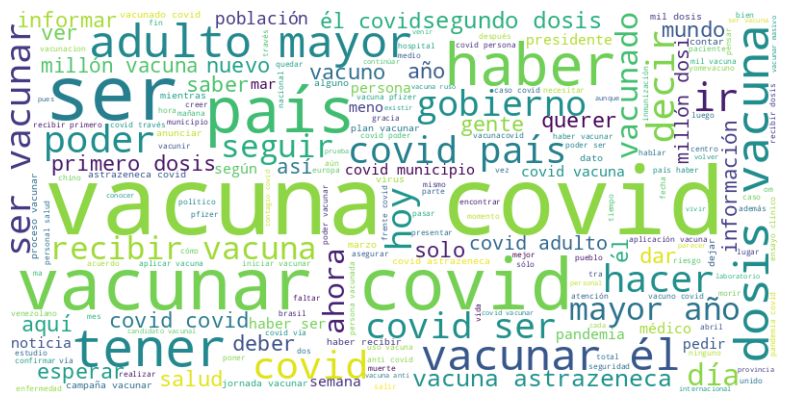

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import itertools


tokens_sin_stopwords = [word for word in list(itertools.chain.from_iterable(tweets['Texto lemma'])) if word.lower() not in stop_words]
texto = ' '.join(tokens_sin_stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



# Vectorizacion con embedding:

Los embeddings capturan información semántica y sintáctica sobre las palabras, lo que te permite realizar diversas tareas de procesamiento de texto utilizando estos vectores de alta dimensionalidad.

Capturar el significado textual de un texto largo: Los embeddings también pueden utilizarse para capturar el significado contextual de un texto más largo, como una oración o un documento. Una forma común de hacer esto es promediando los vectores de las palabras que componen el texto. El proceso sería el siguiente:

Paso 1: Para cada palabra en el texto, se obtiene su vector de embedding.

Paso 2: Se promedian todos los vectores de embedding de las palabras del texto para obtener un vector promedio.

Paso 3: El vector promedio resultante representa el significado contextual del texto.

Al promediar los vectores de las palabras, se capturan las características semánticas del texto en su conjunto. Por ejemplo, si el texto contiene las palabras "gato", "animal" y "doméstico", el vector promedio capturará la idea general de un animal doméstico relacionado con los gatos.

## Word2vec
 Es un modelo popular que utiliza redes neuronales para aprender embeddings de palabras. Puede entrenarse en grandes corpus de texto y genera representaciones vectoriales densas para las palabras. Word2Vec puede capturar relaciones semánticas y sintácticas entre las palabras.


El funcionamiento básico de Word2Vec se basa en dos arquitecturas principales: Skip-gram y CBOW (Continuous Bag of Words). Ambas arquitecturas son modelos de redes neuronales que aprenden a predecir las palabras circundantes a una palabra objetivo en un contexto dado.

Arquitectura Skip-gram: En esta arquitectura, el objetivo es predecir las palabras vecinas dada una palabra objetivo. Por ejemplo, si tenemos la oración "El gato está durmiendo en la alfombra", y elegimos "durmiendo" como palabra objetivo, el modelo intentará predecir las palabras vecinas como "está", "en" y "la". El modelo ajusta sus pesos a medida que avanza en el corpus para maximizar la probabilidad de predecir correctamente las palabras vecinas.

Arquitectura CBOW: En esta arquitectura, el objetivo es predecir la palabra objetivo dadas las palabras vecinas en un contexto. Utilizando el mismo ejemplo anterior, si tenemos las palabras vecinas "está", "en" y "la", el modelo intentará predecir la palabra objetivo "durmiendo". Al igual que en Skip-gram, el modelo ajusta sus pesos para maximizar la probabilidad de predecir correctamente la palabra objetivo.

La **muestra negativa** se utiliza para generar ejemplos falsos al seleccionar palabras que no están en el contexto. El objetivo es que el modelo aprenda a distinguir entre palabras reales (positivas) y palabras falsas (negativas) en el contexto.

La muestra negativa ayuda a mejorar la calidad de los vectores de palabras, ya que obliga al modelo a aprender a diferenciar entre palabras que están realmente relacionadas en el contexto y palabras que no lo están. Esto permite capturar mejor las relaciones semánticas y mejorar la capacidad del modelo para realizar tareas como la búsqueda de palabras similares o el análisis de similitud entre palabras.

In [ ]:
#Paqueteria requerida para embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import np_utils
import tensorflow as tf
from gensim.models import word2vec, FastText


En la biblioteca `gensim` de Python, los principales parámetros del modelo `Word2Vec` son los siguientes:

- `sentences`: Los datos de entrada, que deben ser una lista de listas de palabras tokenizadas.
- `size`: La dimensión del espacio vectorial en el que se generan los embeddings de palabras. Representa el tamaño del vector de características para cada palabra. Por defecto es 100.
- `window`: La ventana de contexto utilizada para predecir una palabra dada una palabra de contexto. Especifica la cantidad máxima de palabras que se consideran a cada lado de la palabra objetivo. Por defecto es 5.
- `min_count`: El umbral de frecuencia mínimo para una palabra. Las palabras que ocurren menos veces que este umbral se ignoran en el modelo. Por defecto es 5.
- `sg`: El algoritmo utilizado para entrenar el modelo. `sg=0` corresponde al modelo CBOW (Continuous Bag of Words) y `sg=1` corresponde al modelo Skip-gram. Por defecto es 0 (CBOW).
- `hs`: Si es 1, se utiliza la jerarquía softmax para el entrenamiento, lo que acelera el proceso de entrenamiento y mejora la calidad de los embeddings. Si es 0, se utiliza el muestreo negativo. Por defecto es 0.
- `negative`: La cantidad de muestras negativas utilizadas para el muestreo negativo. Por defecto es 5.
- `workers`: La cantidad de hilos de procesamiento para entrenar el modelo. Por defecto es 3.
- `epochs`: El número de iteraciones sobre el corpus de entrenamiento. Por defecto es 5.


## Modelo vectorizador word2vec

In [ ]:
#Creamos una new data para usar en los embedding
datos_tokenizados=tweets['Texto lemma']  #.sample(n=5000, random_state=42)

In [ ]:
#Aplicamos el word2vec
from gensim.models import Word2Vec

# Entrenamiento del modelo Word2Vec
modelo = Word2Vec(datos_tokenizados,vector_size=100, sg=0,min_count=5,window=5,
                  hs=0,epochs=5,negative=10,seed=42,workers=1)  # sg=1 para utilizar Skip-gram

# Obtención del embedding de una palabra específica
embedding = modelo.wv['vacuna']

# Obtención de palabras similares a una palabra dada
similares = modelo.wv.most_similar('vacuna')

# Guardar el modelo entrenado
modelo.save('modelo_word2vec.bin')

In [ ]:
#Para poder visualizar un vector del modelo
vector = modelo_pre.wv.get_vector("vacuna")
print(vector)

In [ ]:
# Obtencion de palabras segun similitud del coseno
similares = modelo_pre.wv.most_similar("vacuna",topn=5)
print(similares)

In [ ]:
# Esta funcion esta creada para poder obtener vectores promedios segun el texto correpsondiente
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = word2vec.wv.vector_size #modificado de funcion original
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])


In [ ]:
# Aplicamos funcion anterior
mean_embedding_vectorizer = MeanEmbeddingVectorizer(modelo)
mean_embedded = mean_embedding_vectorizer.transform(tweets['Texto lemma'])
tweets["Vector"]=list(mean_embedded)

In [ ]:
#Visualizacion de data con vectores
tweets[['Text','Texto lemma','Vector']]

# Guardamos el archivo csv para siguiente paso
tweets.to_csv('datosTFM.csv', index=False)

# Analisis de Componentes Princiales PCA

In [ ]:
# Obtener las TOP de palabras más frecuentes como una lista
import tensorflow

top_100 = t_f.nlargest(150, 'TF-IDF')['token lemma'].tolist()
#top_100 =top_words_df.nlargest(150, 'tf-idf')['token'].tolist()
# Matriz de vectores
X =modelo.wv[modelo.wv.index_to_key]
# Label de lo svectores
words = list(modelo.wv.index_to_key)

# Filtrar los vectores Word2Vec y las etiquetas para las 100 palabras más frecuentes
vectors_top_100 = []
labels_top_100 = []
for i, word in enumerate(top_100):
    word_idx = np.where(word == np.array(top_100))[0][0]  # Índice de la palabra en 'word'
    vectors_top_100.append(X[word_idx])
    labels_top_100.append(word)

# Convertir las listas en arrays NumPy
df_top = np.array(vectors_top_100)
lab_top = np.array(labels_top_100)

In [ ]:
#Para normalizar los datos
#----------------NO SE UTILIZO EN EL ESTUDIO-------------------------------------------
from sklearn.preprocessing import Normalizer
norm_df= Normalizer().fit_transform(df_top)

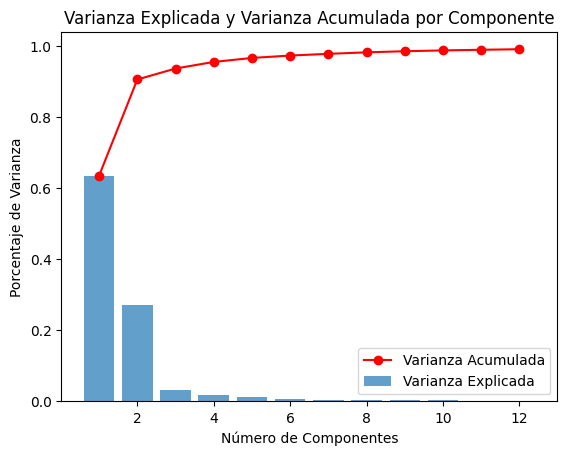

[0.63413465 0.904567   0.9353993  0.9539233  0.96514446 0.9718985
 0.9766368  0.9809047  0.98402023 0.98629993 0.98810977 0.98966855]


In [ ]:
# Aplicacion del analisis PCA que nos ayude a visulizar cuantas componentes a seleccionar

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Crear objeto PCA y ajustarlo a los datos
pca = PCA(n_components=12,random_state=42)
pca.fit(df_top)

# Obtener la varianza explicada por cada componente
variance_explained = pca.explained_variance_ratio_

# Calcular la varianza acumulada para cada número de componentes
cumulative_variance = np.cumsum(variance_explained)

# Crear un gráfico de barras para la varianza explicada
plt.bar(range(1, len(variance_explained) + 1), variance_explained, label='Varianza Explicada', alpha=0.7)

# Crear un gráfico de línea para la varianza acumulada
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', label='Varianza Acumulada')

# Agregar etiquetas y título al gráfico
plt.xlabel('Número de Componentes')
plt.ylabel('Porcentaje de Varianza')
plt.title('Varianza Explicada y Varianza Acumulada por Componente')
plt.legend()

# Mostrar el gráfico
plt.show()
print(cumulative_variance)

In [ ]:
#Matriz de correlacion
df_top=pd.DataFrame(df_top)
cor=df_top.corr()
print(cor)

In [ ]:
# Se modela PCA y se selecciona los dos primeros componentes
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2,random_state=42) # 50% de la varianza
result = pca.fit_transform(df_top)

#create df from the pca results
pca_df = pd.DataFrame(result,columns=['c1','c2'])  #,'c3','c4','c5'

#add the words for the hover effect
pca_df['word'] = lab_top
pca_df

,c1,c2,word
0,0.964377,0.355721,vacunar
1,-0.514734,2.088451,vacuna
2,1.149712,-2.112649,país
3,-0.166915,1.204152,dosis
4,2.636634,3.239871,vacuno
...,...,...,...
145,-0.744464,0.267923,importante
146,0.769418,0.242811,faltar
147,-0.559644,-0.281215,sinovac
148,0.170004,-0.551581,mismo


In [ ]:
# Preparar Dataframe para que incluya los vectores de las dos componentes obtendias con PCA

#df_frecuencia_top=df_frecuencia.head(100)
tfidf=pd.DataFrame(t_f).sort_values(by="TF-IDF", ascending=False).head(150)
#top_words_df.head(150)
#PCA_data_top = pca_df.merge(top_words_df, how='inner', left_on='word',right_on='token')
PCA_data_top=pca_df.merge(t_f,how='left',left_on='word',right_on='token lemma')

# Para usarlos en el cluster, de forma que solo tenga los valores de los componentes principales(2)
pca_result = pca_df[['c1','c2']].values
pca_lab=pca_df['word'].tolist()


# Grafico de dispersion:

Utilizo la técnica PCA para reducir la dimensionalidad de mis vectores, luego pongo los resultados y las palabras en un marco de datos.

In [ ]:
# Grafico de dispersion de palabras
# https://builtin.com/machine-learning/nlp-word2vec-python

from matplotlib import pyplot as plt
import plotly.graph_objects as go

N = 1000000

fig = go.Figure(data=go.Scattergl(
   x = pca_df['c1'],
   y = pca_df['c2'],
   mode='markers',
   marker=dict(
       color=np.random.randn(N), #generacion de colores aleatorios
       colorscale='Viridis',
       line_width=1
   ),
   text=pca_df['word'],
   textposition="bottom center"
))

fig.show()

# Crear conglomerados:

## K-means

In [ ]:
# Probamos varios numeros de cluster primero para poder determinar cual seria el optimo de mis datos
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# semilla
s=42

# Aplicar K-means con diferentes valores de n_clusters
silueta_scores = []
squared_errors = []
for n in range(2, 20):
    kmeans = KMeans(n_clusters=n,
        max_iter=100,
        n_init=5,
        random_state=s)
    kmeans.fit(pca_result)
    labels = kmeans.labels_
    silueta_scores.append(silhouette_score(pca_result, labels))
    squared_errors.append(kmeans.inertia_)

# Imprimir los valores de coeficiente de silueta y SSE
for n, score, error in zip(range(2, 20), silueta_scores, squared_errors):
    print(f"Clusters = {n}: Silhouette Score = {score}, SSE = {error}") #suma error cuadrado intra cluster Sum of Squared Within (SSW)

Clusters = 2: Silhouette Score = 0.5228231549263, SSE = 205.03321838378906
Clusters = 3: Silhouette Score = 0.4847298562526703, SSE = 151.93638610839844
Clusters = 4: Silhouette Score = 0.33635151386260986, SSE = 115.40228271484375
Clusters = 5: Silhouette Score = 0.3985957205295563, SSE = 85.14445495605469
Clusters = 6: Silhouette Score = 0.393339604139328, SSE = 68.63851928710938
Clusters = 7: Silhouette Score = 0.3375850021839142, SSE = 57.75049591064453
Clusters = 8: Silhouette Score = 0.35242244601249695, SSE = 51.187496185302734
Clusters = 9: Silhouette Score = 0.3623978793621063, SSE = 44.931583404541016
Clusters = 10: Silhouette Score = 0.36293163895606995, SSE = 41.237815856933594
Clusters = 11: Silhouette Score = 0.35759440064430237, SSE = 37.41414260864258
Clusters = 12: Silhouette Score = 0.36892130970954895, SSE = 33.620845794677734
Clusters = 13: Silhouette Score = 0.3698047399520874, SSE = 30.2747859954834
Clusters = 14: Silhouette Score = 0.3694205582141876, SSE = 26.89

In [ ]:
# Crear un DataFrame para almacenar los resultados
results_df = pd.DataFrame({
    'Clusters': range(2, 20),
    'Silhouette Score': silueta_scores,
    'SSE': squared_errors
})

# Imprimir el DataFrame en formato de tabla
#print(results_df)
results_df.to_csv('kmeanIter.csv', index=False)

# Indices de evaluación de clsuter

## Metodo del codo

El método se basa en calcular la suma dentro del clúster de errores al cuadrado (WSS) para diferentes números de clústeres (k) y seleccionar el k para el cual el cambio en WSS comienza a disminuir.

La idea detrás del método del codo es que la variación explicada cambia rápidamente para un pequeño número de grupos y luego se ralentiza, lo que lleva a una formación de codo en la curva. El punto de codo es el número de clústeres que podemos usar para nuestro algoritmo de agrupación.

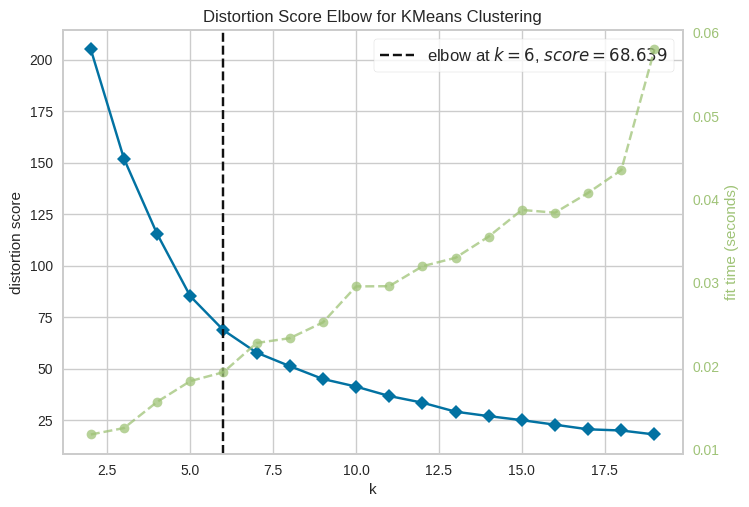

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Elbow Metodo de la paquteria de py
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=s)
visualizer_elbow = KElbowVisualizer(model, k=(2,20), timings= True)
visualizer_elbow.fit(pca_result)

#Aqui elaboramos el grafico a apartir del metodo anterior
scores=visualizer_elbow.k_scores_
centers=list(range(2,20))
max_score_index =6 #visualizer.k_scores_.index(max(visualizer.k_scores_))
processing_times=visualizer_elbow.k_timers_

fig, ax1 = plt.subplots()

# Graficar el score
ax1.plot(centers, scores, linestyle='-', marker='s', color='b',label='Índice de elbow')
ax1.axvline(x=max_score_index, linestyle='--', color='black', label=f'k: {max_score_index}')
ax1.set_xlabel('Número de cluster')
ax1.set_ylabel('Valor del índice')


# Agregar eje y secundario para el tiempo de procesado

ax2 = ax1.twinx()
ax2.plot(centers, processing_times, linestyle='--', marker='o', color='gray', label='Tiempo de Procesado')
ax2.set_ylabel('Tiempo de Procesado (segundos)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Mostrar leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right',ncol=3,fontsize=8)

plt.show()

## Metodo de Silueta

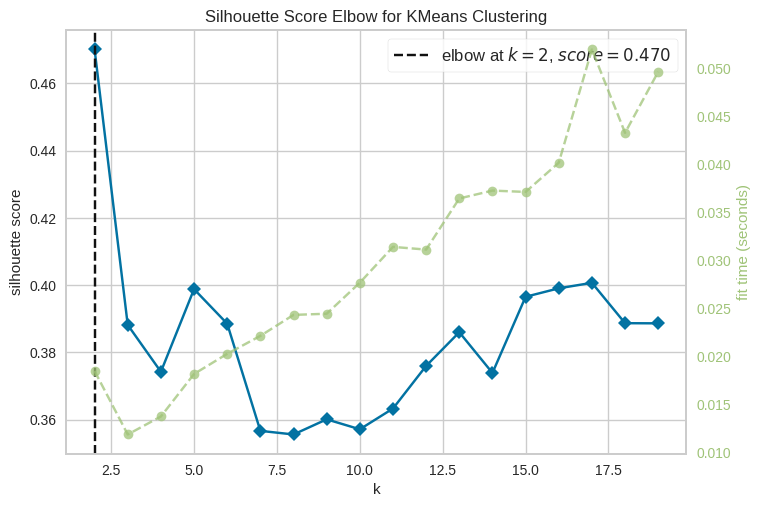

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [ ]:
# Silhouette Score
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=s)
visualizer = KElbowVisualizer(model, k=(2,20),metric='silhouette', timings= True)
visualizer.fit(pca_result)

#Aqui elaboramos el grafico de silueta a partir del metodo scores=visualizer_sil.k_scores_
centers=list(range(2,20))
max_score_index =2 #visualizer.k_scores_.index(max(visualizer.k_scores_))
processing_times=visualizer_sil.k_timers_

fig, ax1 = plt.subplots()

# Graficar el score
ax1.plot(centers, scores, linestyle='-', marker='s', color='b',label='Índice de silueta')
ax1.axvline(x=max_score_index, linestyle='--', color='black', label=f'k: {max_score_index}')
ax1.set_xlabel('Número de cluster')
ax1.set_ylabel('Valor del índice')


# Agregar eje y secundario para el tiempo de procesado

ax2 = ax1.twinx()
ax2.plot(centers, processing_times, linestyle='--', marker='o', color='gray', label='Tiempo de Procesado')
ax2.set_ylabel('Tiempo de Procesado (segundos)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Mostrar leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2,  loc='upper right',ncol=3,fontsize=8)

plt.show()anterior



## Indice Calinski Harabasz

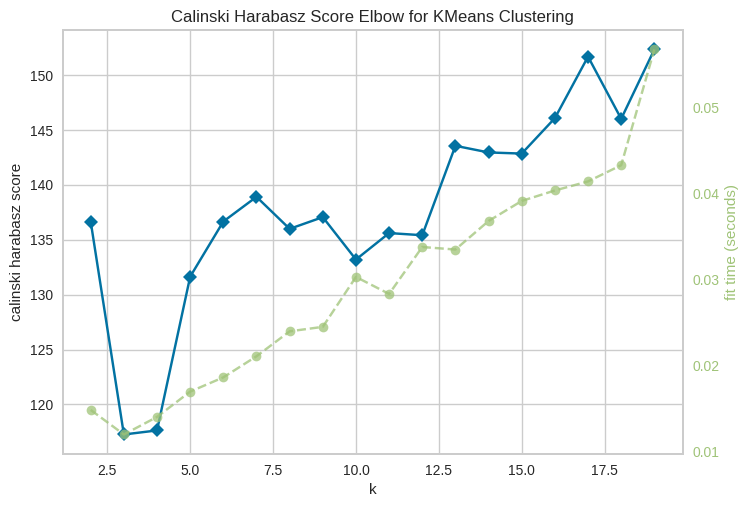

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [ ]:
# Calinski Harabasz Score
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=s)
visualizer = KElbowVisualizer(model, k=(2,20),metric='calinski_harabasz', timings= True,locate_elbow=False)
visualizer.fit(pca_result)

#Grafico
scores=visualizer.k_scores_
centers=list(range(2,20))
max_score_index =19 #visualizer.k_scores_.index(max(visualizer.k_scores_))
processing_times=visualizer.k_timers_

fig, ax1 = plt.subplots()

# Graficar el Davies Bouldin score
ax1.plot(centers, scores, linestyle='-', marker='s', color='b',label='Índice de Calinski Harabasz')
ax1.axvline(x=max_score_index, linestyle='--', color='black', label=f'k: {max_score_index}')
ax1.set_xlabel('Número de cluster')
ax1.set_ylabel('Valor del índice')


# Agregar eje y secundario para el tiempo de procesado

ax2 = ax1.twinx()
ax2.plot(centers, processing_times, linestyle='--', marker='o', color='gray', label='Tiempo de Procesado')
ax2.set_ylabel('Tiempo de Procesado (segundos)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Mostrar leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2,  loc='upper right',ncol=3,fontsize=8)

plt.show()


## Indice de Davies Bouldin

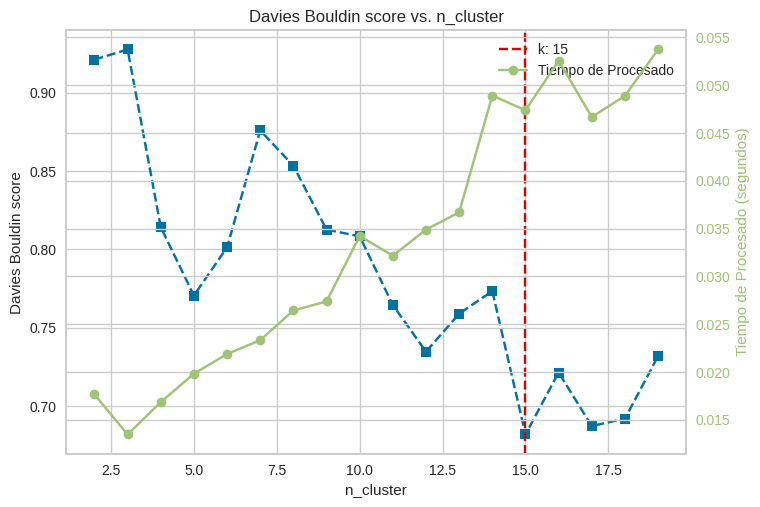

In [ ]:
# Davies Bouldin score for K means
import time
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center,random_state=s) #random evita que sea aleatorice el modelo kmean asegura reproducirlo

    model = kmeans.fit_predict(pca_result,)

    # Calculate Davies Bouldin score
    score = davies_bouldin_score(pca_result, model)

    return score

scores = []
centers = list(range(2, 20))
processing_times = []

for center in centers:
    start_time = time.time()
    scores.append(get_kmeans_score(pca_result, center))
    end_time = time.time()
    processing = end_time - start_time
    processing_times.append(processing)

# Encuentra el índice del score mínimo y obtén el centro correspondiente
min_score_idx = scores.index(min(scores))
min_score_center = centers[min_score_idx]

fig, ax1 = plt.subplots()

# Graficar el DB score
ax1.plot(centers, scores, linestyle='-', marker='s', color='b',label='Índice de Davies Bouldien')
ax1.axvline(x=min_score_center, linestyle='--', color='black', label=f'k: {min_score_center}')
ax1.set_xlabel('Número de cluster')
ax1.set_ylabel('Valor del índice')
#ax1.set_title('Davies Bouldin score vs. n_cluster')

# Agregar eje y secundario para el tiempo de procesado
ax2 = ax1.twinx()
ax2.plot(centers, processing_times, linestyle='--', marker='o', color='gray', label='Tiempo de Procesado')
ax2.set_ylabel('Tiempo de Procesado (segundos)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Mostrar leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2,  loc='upper right',ncol=3,fontsize=8)

plt.show()


## GAP estadistico

## Indice de Dunn

18


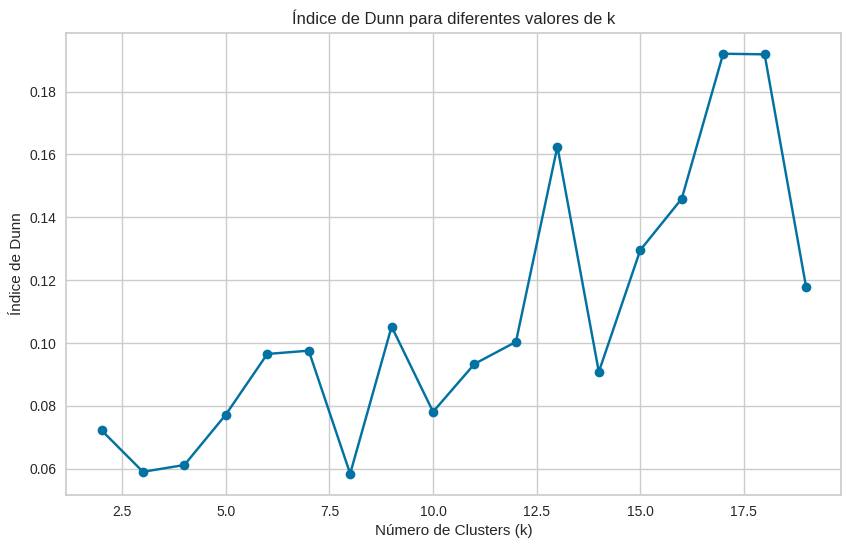

In [ ]:
# Calculo del indice de Dunn:
# se calcula como el cociente entre la mínima distancia entre dos puntos de diferentes clusters y
# la máxima distancia entre dos puntos dentro del mismo cluster.
# Un valor más alto del índice de Dunn indica una mejor separación entre los clusters.

from scipy.spatial.distance import cdist

# Rango de valores de k para probar (por ejemplo, de 2 a 20)
k_values = range(2, 20)

def dunn_index(X, labels):
    # Calcula la dispersión intra-cluster
    intra_cluster_distances = []
    for cluster in np.unique(labels):
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            intra_distance = np.mean(cdist(cluster_points, cluster_points))
            intra_cluster_distances.append(intra_distance)

    # Calcula la dispersión inter-cluster
    inter_cluster_distances = []
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if labels[i] != labels[j]:
                distance = np.linalg.norm(X[i] - X[j])
                inter_cluster_distances.append(distance)

    # Calcula el índice de Dunn
    dunn_index = min(inter_cluster_distances) / max(intra_cluster_distances)

    return dunn_index



# Calculamos
dunn_scores = []
processing_times = []

processing_times = []
for k in k_values:
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, random_state=s)
    labels = kmeans.fit_predict(pca_result)
    end_time = time.time()
    processing_time = end_time - start_time
    processing_times.append(processing_time)


k_values = range(2, 20)
# Calcular el índice de Dunn para diferentes valores de k (2 a 30)
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=s)
    clusters = kmeans.fit_predict(pca_result)
    dunn_score = dunn_index(pca_result, clusters)
    dunn_scores.append(dunn_score)
print(len(dunn_scores))

# Encuentra el índice del score mínimo y obtén el centro correspondiente
mx_score_indx = dunn_scores.index(max(dunn_scores))
mx_score = centers[mx_score_indx]

fig, ax1 = plt.subplots()

# Graficar los resultados del índice de Dunn
ax1.plot(range(2, 20), dunn_scores, marker='o', linestyle='-', color='b',label='Índice de Dunn')
ax1.axvline(x=mx_score, linestyle='--', color='black', label=f'k: {mx_score}')
ax1.set_xlabel('Número de cluster (k)')
ax1.set_ylabel('Valor del índice')
#ax1.title('Índice de Dunn para diferentes valores de k')


# Agregar eje y secundario para el tiempo de procesado
ax2 = ax1.twinx()
ax2.plot(centers, processing_times, linestyle='--', marker='o', color='gray', label='Tiempo de Procesado')
ax2.set_ylabel('Tiempo de Procesado (segundos)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Mostrar leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right',ncol=3,fontsize=8)

plt.show()

## Indice de hartigan

[0.6546650469711119, 0.5407142749416548, 0.7115752624186258, 0.7797335120682604, 0.8130050037533382, 0.881600204136974, 0.958345184797148, 0.9903374497717243, 1.1261521193049293, 1.0971382458618757, 1.2040439609083091, 1.2240416914194765, 1.2602934103439996, 1.349609632706513, 1.3637998054753406, 1.367653732837198, 1.4503224909045844, 1.400975921919274]


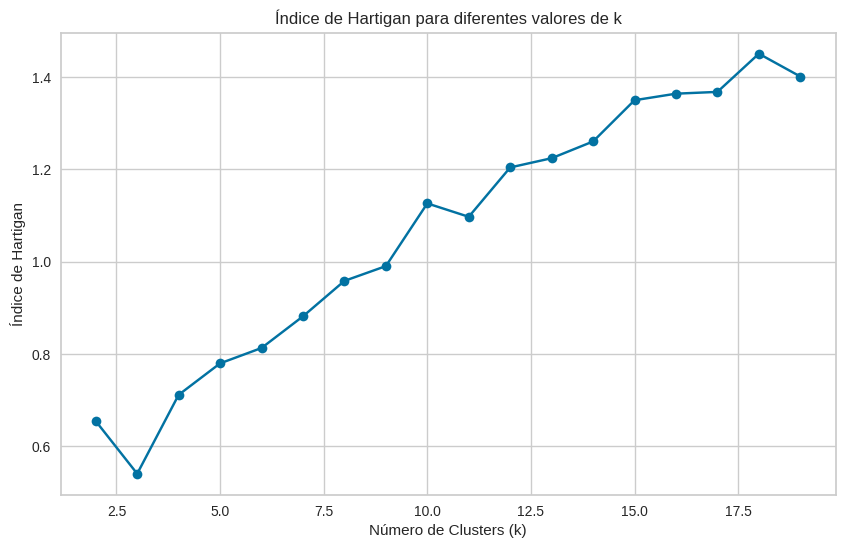

In [ ]:
#Indice de hartigan log(SSB/SSW)
from scipy.spatial.distance import cdist

def hartigan_index(X, labels):
    # Calcula la dispersión intra-cluster
    intra_cluster_distances = []
    for cluster in np.unique(labels):
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            intra_distance = np.mean(cdist(cluster_points, cluster_points))
            intra_cluster_distances.append(intra_distance)

    # Calcula la dispersión inter-cluster
    inter_cluster_distances = []
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            if labels[i] != labels[j]:
                distance = np.linalg.norm(X[i] - X[j])
                inter_cluster_distances.append(distance)

    # Calcula el índice de Hartigan
    hartigan_index = np.log(np.mean(inter_cluster_distances) / np.mean(intra_cluster_distances))

    return hartigan_index


# Calculamos
hartigan_scores = []
processing_times = []

processing_times = []
for k in k_values:
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, random_state=s)
    labels = kmeans.fit_predict(pca_result)
    end_time = time.time()
    processing_time = end_time - start_time
    processing_times.append(processing_time)
# Calcular el índice de Dunn para diferentes valores de k (2 a 20)
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=s)
    clusters = kmeans.fit_predict(pca_result)
    hartigan_score = hartigan_index(pca_result, clusters)
    hartigan_scores.append(hartigan_score)



# Encuentra el índice del score mínimo y obtén el centro correspondiente
mx_score_indx = hartigan_scores.index(max(hartigan_scores))
mx_score = centers[mx_score_indx]

fig, ax1 = plt.subplots()

# Graficar los resultados del índice de Dunn
ax1.plot(range(2, 20), hartigan_scores, marker='o', linestyle='-', color='b',label='Índice de Hartigan')
ax1.axvline(x=mx_score, linestyle='--', color='black', label=f'k: {mx_score}')
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Valor del índice')


# Agregar eje y secundario para el tiempo de procesado
ax2 = ax1.twinx()
ax2.plot(centers, processing_times, linestyle='--', marker='o', color='gray', label='Tiempo de Procesado')
ax2.set_ylabel('Tiempo de Procesado (segundos)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Mostrar leyendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2,  loc='upper right',ncol=3,fontsize=8)

plt.show()

In [ ]:
# Creamos el modelo kmean final
k=19
for seed in range(k):
    kmeans_vec = KMeans(
        n_clusters=k,
        max_iter=100,
        n_init=5,
        random_state=42,
    ).fit(pca_result)
    cluster_ids, cluster_sizes = np.unique(kmeans_vec.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()

Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8  2  3  9 13  4  2  7 17  4 25  3  3  1]
Number of elements assigned to each cluster: [19  4 11  3 12  8 

In [ ]:
#Crear grafico de los cluster
from numpy import unique
from numpy import where

# Supongamos que kmeans_labels son las etiquetas de clúster devueltas por k-means
kmeans_labels = kmeans_vec.predict(pca_result)
# Para truncar los label de los cluster y que empiecen en 1 no en 0
kmeans_labels = [label + 1 for label in kmeans_labels]

# Recupera los clústeres únicos
clusters = unique(kmeans_labels)

# Define un mapa de colores personalizado con colores únicos para cada cluster
custom_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 'tab:orange', 'tab:green',
                 'tab:red', 'tab:purple', 'tab:olive', 'tab:pink', 'tab:gray',  'tab:cyan', 'tab:blue', 'salmon','lime']

# Crea un diccionario para mapear el número de clúster a su respectiva leyenda y color
cluster_legend = {cluster: f'Cluster {cluster}' for cluster in clusters}
cluster_colors = {cluster: color for cluster, color in zip(clusters, custom_colors)}

# Crea el gráfico y agrega una leyenda para cada clúster
for cluster in clusters:
    row_ix = where(kmeans_labels == cluster)
    plt.scatter(pca_result[row_ix, 0], pca_result[row_ix, 1], label=cluster_legend[cluster], c=cluster_colors[cluster])

# Trazar los centros de clúster como "x"
reduced_cluster_centers = kmeans_vec.cluster_centers_
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='x', s=120, color='black')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# Muestra la leyenda fuera del gráfico y ajusta su posición
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Muestra el gráfico
plt.show()

In [ ]:
# Imprimir los términos de cada cluster

from gensim.models import Word2Vec
from sklearn.cluster import KMeans

# Obtener los términos de cada cluster
clusters = kmeans_vec.labels_
vocab =list(modelo.wv.index_to_key)

# Crear un diccionario para almacenar los términos de cada cluster
terminos_clusters = {}
for cluster_id in range(k):
    terminos_cluster = [lab_top[i] for i in range(len(clusters)) if clusters[i] == cluster_id]
    terminos_clusters[cluster_id] = terminos_cluster

# Imprimir
for cluster_id, terminos in terminos_clusters.items():
    print(f"Cluster {cluster_id}: {terminos}")


In [ ]:
# Calcular el coeficiente de silueta para cada muestra
from sklearn.metrics import silhouette_samples

PCA_data_top["K"]=kmeans_vec.labels_

sil_values = silhouette_samples(pca_result, kmeans_vec.labels_)

# Agregar el coeficiente de silueta al DataFrame
PCA_data_top['Silueta kmean'] = sil_values

# Imprimir el coeficiente de silueta promedio para cada clúster
for cluster_num in range(n):
    cluster_avg = PCA_data_top[PCA_data_top['K'] == cluster_num]['Silueta kmean'].mean()
    print(f"Cluster {cluster_num}: Coeficiente de Silueta Promedio = {cluster_avg}")

Cluster 0: Coeficiente de Silueta Promedio = 0.33815282583236694
Cluster 1: Coeficiente de Silueta Promedio = 0.44759297370910645
Cluster 2: Coeficiente de Silueta Promedio = 0.3405332863330841
Cluster 3: Coeficiente de Silueta Promedio = 0.7668238282203674
Cluster 4: Coeficiente de Silueta Promedio = 0.33455169200897217
Cluster 5: Coeficiente de Silueta Promedio = 0.36833611130714417
Cluster 6: Coeficiente de Silueta Promedio = 0.8008689880371094
Cluster 7: Coeficiente de Silueta Promedio = 0.6697545051574707
Cluster 8: Coeficiente de Silueta Promedio = 0.5098278522491455
Cluster 9: Coeficiente de Silueta Promedio = 0.39612916111946106
Cluster 10: Coeficiente de Silueta Promedio = 0.15852846205234528
Cluster 11: Coeficiente de Silueta Promedio = 0.19917522370815277
Cluster 12: Coeficiente de Silueta Promedio = 0.4366283714771271
Cluster 13: Coeficiente de Silueta Promedio = 0.32846516370773315
Cluster 14: Coeficiente de Silueta Promedio = 0.2595135569572449
Cluster 15: Coeficiente de 

In [ ]:
len(PCA_data_top)

# Tabla final

In [ ]:
#PASO 1:

# Agregar el coeficiente de silueta al DataFrame
PCA_data_top['Siluetas K'] = sil_values

# Agrupa los datos por el campo 'Cluster' y encuentra el índice del máximo valor en 'Conteo'
max_ind = PCA_data_top.groupby('K')['count'].idxmax()

# Obtiene los datos correspondientes al término con la mayor frecuencia en cada cluster
terms_comun= PCA_data_top.loc[max_ind, 'word']
t_counts = PCA_data_top.loc[max_ind, 'count']

# Crear un nuevo DataFrame para mostrar los resultados
result_km = pd.DataFrame({'Cluster': PCA_data_top.loc[max_ind, 'K'],
                          'Most_Term': terms_comun,
                          'Count': t_counts})

# Agrupar los datos en 'pca' por el label del cluster y calcular la media de la silueta
sil_values = PCA_data_top.groupby('K')['Siluetas K'].mean()

# Unir la información del término más usado y su conteo desde 'result_df' con la información de la silueta
result_km = result_km.merge(sil_values, left_on='Cluster', right_index=True)

# Renombrar la columna de silueta a 'Silueta'
result_km.rename(columns={'Siluetas K': 'Silueta K'}, inplace=True)

# Agrupar los datos en 'pca' por el label del cluster y crear la lista de términos para cada grupo
term_lists = PCA_data_top.groupby('K')['word'].apply(list)

# Unir la lista de términos con el DataFrame 'result_df'
result_km['Terminos'] = term_lists.values

print(result_km)

     Cluster    Most_Term  Count  Silueta K  \
32         0         caso    392   0.338153   
12         1  astrazeneca    795   0.447593   
0          2      vacunar   4218   0.340533   
6          3          año   1031   0.766824   
9          4        salud    862   0.334552   
11         5        covid  10302   0.368336   
1          6       vacuna   6064   0.800869   
7          7        poder   1006   0.669755   
17         8       adulto    726   0.509828   
3          9        dosis   1833   0.396129   
21        10          ser    593   0.158528   
4         11       vacuno   1337   0.199175   
10        12      persona    856   0.436628   
8         13     vacunado    912   0.328465   
2         14         país   2308   0.259514   
30        15      segundo    445   0.377548   
5         16        mayor   1070   0.456122   
112       17       ciudad    148   0.542915   
34        18        marzo    370   0.000000   

                                              Terminos  
32

In [ ]:
#PASO 2:

top3=PCA_data_top.groupby('K')['count'].nlargest(3)

# Calcular el top 3 de conteos para cada etiqueta de cluster
top3_counts = PCA_data_top.groupby('K')['count'].nlargest(3)
total=PCA_data_top.groupby('K')['count'].sum()

# Obtener los top 3 términos por cluster
top3_terms = PCA_data_top.groupby('K').apply(lambda x: x.nlargest(3, 'count')['word'].tolist())

# Obtener los top 3 términos y conteos como listas

top3_counts_list = []
for group, counts in top3_counts.groupby(level=0):
      top3_counts_list.append(list(counts.values))

# Agregar las listas y el total al DataFrame original
result_km['Top3Terminos'] =result_km['Cluster'].map(top3_terms)
result_km['Top3Conteos'] = top3_counts_list
result_km['TotalConteosTop3'] = top3_counts.groupby(level=0).sum().tolist()
result_km['Totalcluster']=result_km['Cluster'].map(total)
result_km['Peso']=result_km['TotalConteosTop3'] /result_km['Totalcluster']
print(result_km)


     Cluster    Most_Term  Count  Silueta K  \
32         0         caso    392   0.338153   
12         1  astrazeneca    795   0.447593   
0          2      vacunar   4218   0.340533   
6          3          año   1031   0.766824   
9          4        salud    862   0.334552   
11         5        covid  10302   0.368336   
1          6       vacuna   6064   0.800869   
7          7        poder   1006   0.669755   
17         8       adulto    726   0.509828   
3          9        dosis   1833   0.396129   
21        10          ser    593   0.158528   
4         11       vacuno   1337   0.199175   
10        12      persona    856   0.436628   
8         13     vacunado    912   0.328465   
2         14         país   2308   0.259514   
30        15      segundo    445   0.377548   
5         16        mayor   1070   0.456122   
112       17       ciudad    148   0.542915   
34        18        marzo    370   0.000000   

                                              Terminos  \
3

# Cluster jerarquico:

In [ ]:

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

distancia="manhattan"
# Aplicar jerarquico con diferentes valores de n_clusters
silueta_scores = []
cohesion = []
for n in range(2, 20):
    kj = AgglomerativeClustering(n_clusters=n,linkage='average',metric=distancia,distance_threshold=None)
    kluster=kj.fit_predict(pca_result)
    labels = kj.labels_
    silueta_scores.append(silhouette_score(pca_result, labels))
    cohesion.append(calinski_harabasz_score(pca_result, kluster))

# Imprimir los valores de coeficiente de silueta y SSE
for n, score, error in zip(range(2, 20), silueta_scores, cohesion):
    print(f"Clusters = {n}: Silhouette Score = {score}, cohesion = {error}")

Clusters = 2: Silhouette Score = 0.5627978444099426, cohesion = 50.47244472555019
Clusters = 3: Silhouette Score = 0.5041822791099548, cohesion = 34.89084165478441
Clusters = 4: Silhouette Score = 0.48019084334373474, cohesion = 72.65774569623294
Clusters = 5: Silhouette Score = 0.39046967029571533, cohesion = 59.85315441348776
Clusters = 6: Silhouette Score = 0.3881828188896179, cohesion = 52.27581571703681
Clusters = 7: Silhouette Score = 0.3759008049964905, cohesion = 49.550901990130036
Clusters = 8: Silhouette Score = 0.3567383885383606, cohesion = 43.746861815803754
Clusters = 9: Silhouette Score = 0.3672088384628296, cohesion = 69.18899732694099
Clusters = 10: Silhouette Score = 0.3598968982696533, cohesion = 62.799513280578644
Clusters = 11: Silhouette Score = 0.38352638483047485, cohesion = 88.64230247068663
Clusters = 12: Silhouette Score = 0.3762441873550415, cohesion = 81.77276890519082
Clusters = 13: Silhouette Score = 0.37162402272224426, cohesion = 84.07222748004419
Clust

In [ ]:
# Realizar el clúster jerárquico utilizando AgglomerativeClustering
#np.random.seed (42)
clustering = AgglomerativeClustering(n_clusters=10,linkage='average',metric=distancia,distance_threshold=None) #2.5
cluster_labels = clustering.fit_predict(pca_result)

# Calcular la silueta y la cohesión
silhouette = silhouette_score(pca_result, cluster_labels)
cohesion = calinski_harabasz_score(pca_result, cluster_labels)

print('Numero de cluster creados:',clustering.n_clusters_)
print("Silueta:", silhouette)
print("Cohesión:", cohesion)

Numero de cluster creados: 10
Silueta: 0.27129528
Cohesión: 40.777398547021605


In [ ]:
# PCA CLUSTER: Agregar las etiquetas de clústeres al DataFrame original
PCA_data_top['Cluster'] = clustering.labels_
n=clustering.n_clusters_
# Agrupar las palabras por clúster y ver las palabras asociadas a cada grupo
clusters = {}
for cluster_num in range(n):
    words_in_cluster = PCA_data_top[PCA_data_top['Cluster'] == cluster_num]['word'].tolist()
    clusters[cluster_num] = words_in_cluster

# Imprimir las palabras asociadas a cada clúster
for cluster_num, words in clusters.items():
    print(f"Cluster {cluster_num}: {words}")

Cluster 0: ['vacunar', 'dosis', 'mayor', 'vacunado', 'salud', 'persona', 'adulto', 'mil', 'ir', 'gobierno', 'decir', 'seguir', 'vacunar él', 'nuevo', 'segundo', 'deber', 'caso', 'población', 'personal', 'través', 'ahora', 'esperar', 'pfizer', 'vía', 'saber', 'mundo', 'querer', 'médico', 'pandemia', 'noticia', 'aquí', 'plan', 'información', 'dos', 'nacional', 'presidente', 'gente', 'contagio', 'campaña', 'riesgo', 'chino', 'centro', 'virus', 'proceso', 'después', 'anunciar', 'tras', 'gracias', 'informar', 'comenzar', 'mes', 'bien', 'cómo', 'ver', 'dato', 'paciente', 'mejor', 'pedir', 'cada', 'medida', 'morir', 'uso', 'aplicado', 'según', 'aún', 'próximo', 'total', 'mientras', 'partir', 'estudio', 'ensayo', 'oms', 'vez', 'hospital', 'muerte', 'público', 'suspender', 'fase', 'efecto', 'mar', 'momento', 'variante', 'sanitario', 'contar', 'dejar', 'seguro', 'clínico', 'medio', 'sputnik', 'covax', 'buen', 'trabajador', 'trabajar', 'anticuerpo', 'hora', 'grupo', 'pueblo', 'creer', 'lunes', 'v

In [ ]:
# Calcular el coeficiente de silueta para cada muestra
from sklearn.metrics import silhouette_samples

silhouette_values = silhouette_samples(pca_result, cluster_labels)

# Agregar el coeficiente de silueta al DataFrame
PCA_data_top['Silhouette'] = silhouette_values

# Imprimir el coeficiente de silueta promedio para cada clúster
for cluster_num in range(n):
    cluster_silhouette_avg = PCA_data_top[PCA_data_top['Cluster'] == cluster_num]['Silhouette'].mean()
    print(f"Cluster {cluster_num}: Coeficiente de Silueta Promedio = {cluster_silhouette_avg}")


In [ ]:
# Agregar el coeficiente de silueta al DataFrame
PCA_data_top['Siluetas'] = silhouette_values

In [ ]:
# Agrupa los datos por el campo 'Cluster' y encuentra el índice del máximo valor en 'Conteo'
max_indices = PCA_data_top.groupby('Cluster')['count'].idxmax()

# Obtiene los datos correspondientes al término con la mayor frecuencia en cada cluster
most_common_terms = PCA_data_top.loc[max_indices, 'word']
term_counts = PCA_data_top.loc[max_indices, 'count']

# Crear un nuevo DataFrame para mostrar los resultados
result_df = pd.DataFrame({'Cluster': PCA_data_top.loc[max_indices, 'Cluster'],
                          'Most_Term': most_common_terms,
                          'Count': term_counts})

# Agrupar los datos en 'pca' por el label del cluster y calcular la media de la silueta
silhouette_values = PCA_data_top.groupby('Cluster')['Siluetas'].mean()

# Unir la información del término más usado y su conteo desde 'result_df' con la información de la silueta
result_df = result_df.merge(silhouette_values, left_on='Cluster', right_index=True)

# Renombrar la columna de silueta a 'Silueta'
result_df.rename(columns={'Siluetas': 'Silueta'}, inplace=True)

# Agrupar los datos en 'pca' por el label del cluster y crear la lista de términos para cada grupo
term_lists = PCA_data_top.groupby('Cluster')['word'].apply(list)

# Unir la lista de términos con el DataFrame 'result_df'
result_df['Terminos'] = term_lists.values

print(result_df)





# Dendograma y cophenetico

El coeficiente cophenético mide la correlación entre las distancias originales entre los puntos y las distancias copheneticas, que son las distancias entre los puntos en el dendrograma resultante del clustering jerárquico.

El coeficiente cophenético tiene valores entre 0 y 1, donde un valor más cercano a 1 indica una mejor estructura de clustering jerárquico.

En una dimension de 100 con CBOW y muestreo negativo y ventana en 5 tenemos este resultado... pero si bajamos la dimension, y la ventana de muestre negativo tenemos resultados en los cuales predomina un solo color.

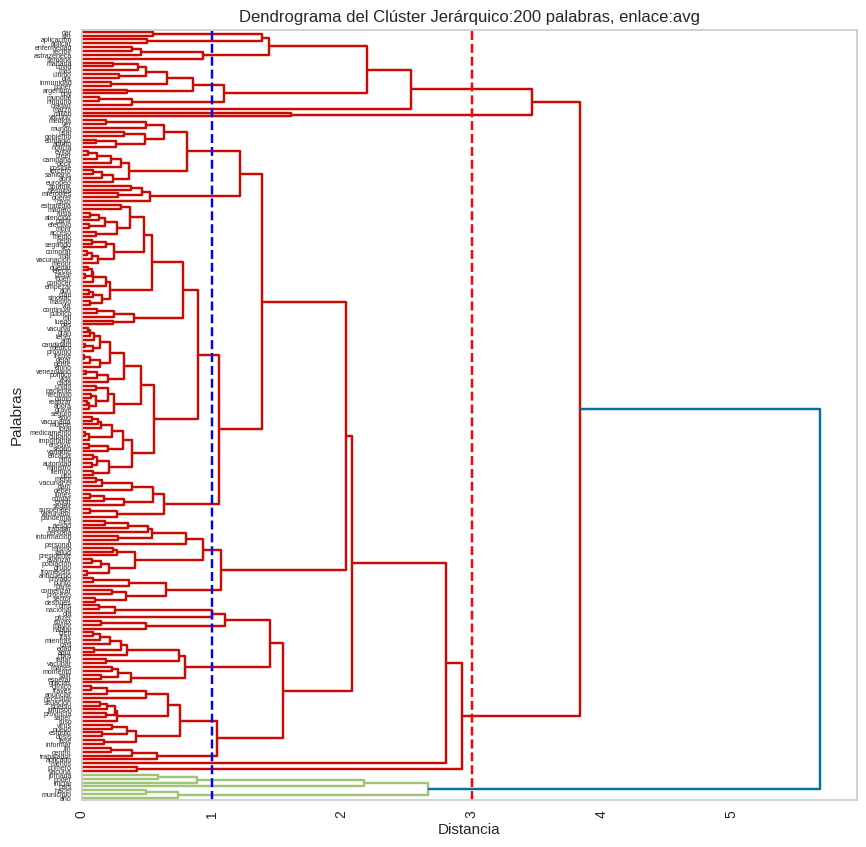

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist, squareform

# Realizar el clúster jerárquico utilizando linkage para obtener las distancias
Z =linkage(pca_result, method='average',metric='cityblock')

# corte óptimo
optimal_threshold = 3
optimal_threshold2 = 1
# Crear el dendrograma
plt.figure(figsize=(10, 10))
dendrogram(Z, labels=pca_lab ,leaf_font_size=5,orientation='right')
plt.title('Dendrograma del Clúster Jerárquico:200 palabras, enlace:avg')
plt.xlabel('Distancia')
plt.ylabel('Palabras')
plt.xticks(rotation=90)
plt.grid()

# Agregar la línea punteada para indicar el corte óptimo
plt.axvline(x=optimal_threshold, color='red', linestyle='dashed')
plt.axvline(x=optimal_threshold2, color='blue', linestyle='dashed')
plt.show()

In [ ]:
# Calcular las distancias copheneticas
c,coph_dists = cophenet(Z, pdist(pca_result))
#print((coph_dists))
print(c)

0.8275914195452447


# Etiquetado manual

## Extraccion de muestras

In [ ]:
#Se usan los 3 primeros terminos de los cluster para en la columna 'Text'
# en este paso se busca obtener archivos csv para proceder a la revision manual

#terminos = ['caso', 'ahora', 'medico']
#terminos = ['astrazeneca', 'recibir', 'semana']
#terminos = ['salud', 'ser', 'población']
#terminos = ['vacuna', 'país', 'hacer']
#terminos = ['decir', 'pandemia', 'aquí']
#terminos = ['millón', 'ir', 'vacunar él']
#terminos = ['covid', 'gobierno','morir']
#terminos= ['vacuna', 'vacuno', 'dosis']
#terminos=['semana', 'presidente', 'hospital', 'ninguno']
#terminos=['salud', 'población', 'gente', 'plan', 'virus', 'uso', 'muerte', 'covax', 'clínico', 'pueblo', 'ministro', 'mismo']
#terminos=['pandemia', 'aquí', 'menos', 'mañana']
#terminos=['mayor', 'pfizer', 'covax']
#terminos=['vacunar', 'aquí', 'nacional']
#terminos=['año', 'municipio', 'hacer']
#terminos=['poder', 'iniciar', 'jornada']
#terminos=['segundo', 'vía', 'plan']
#terminos=['salud', 'población', 'presidente']
#terminos=['vacuna', 'primero']
#terminos=['dosis', 'nuevo', 'través']
terminos=['anticuerpo', 'grupo', 'punto']
# Filtrar las filas que contienen los términos
#tweets_filtrados = df[df["Texto lemma"].str.contains('|'.join(terminos))]

# Filtrar las listas de tokens que contienen los términos específicos
tweets_filtrados = BD[BD['Texto lemma'].apply(lambda x: buscar_terminos(x,terminos))]

cluster_13=tweets_filtrados[['User ID','Text','Texto lemma']].sample(frac=0.3,replace=False,random_state=1)


# Clasificacion

In [ ]:
# Seleccionar 5 mil twwet como submuestra
sample_tweets=BD[['User ID','Text','Texto lemma']].sample(frac=0.5,replace=False,random_state=42)

In [ ]:
# Lista de listas de tokens de tuits
tuit_tokens = tweets['Texto lemma']

# Función para obtener el vector promedio de un tuit
def obtener_vector_promedio(modelo, tokens):
    vectors = []
    for token in tokens:
        if token in modelo.wv.key_to_index:
            vectors.append(modelo.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(modelo.wv.vector_size)  # Vector de ceros si no hay palabras en el vocabulario

# Calcular los vectores medios para todos los tuits
vectores_medios = [obtener_vector_promedio(modelo, tokens) for tokens in tuit_tokens]

# Asignamos a la base de dtaos
tweets['vec']=(vectores_medios)

# lo volvemos array porque esta en forma de lista
tweets['vec']=np.array(vectores_medios)

## Creacion de etiquetas

In [ ]:
 #Creacion de data para vector y clasificacion
term = {
    'cluster': [
        ['caso', 'ahora', 'medico'],
        ['astrazeneca', 'recibir', 'semana'],
        ['dosis', 'nuevo', 'través'],
        ['adulto', 'gobierno', 'decir'],
        ['segundo', 'vía', 'plan'],
        ['poder', 'iniciar', 'jornada'],
        ['persona', 'ir', 'personal'],
        ['salud', 'población', 'presidente']
    ],
    'etiquetas': [
        'GravedadPercibida',
        'BarreraPercibida',
        'BeneficioPercibida',
        'Vulnerabilidad',
        'SuceptibilidadPercibida',
        'JornadasVacunacion',
        'PersonalMedicoFrente',
        'RiesgoSaludNacional'
    ]
}

terminos=pd.DataFrame(term)

# Tu DataFrame original con 5000 tuits
sample_tweets = BD[['User ID', 'Text', 'Texto lemma','vec']].sample(frac=0.5, replace=False, random_state=42)

# Lista para guardar los User ID que ya se han asignado a un cluster
user_ids_asignados = []

# Diccionario para almacenar los clusters
clusters = {}

# Iterar a través de los clusters definidos
for i, cluster_terms in enumerate(term['cluster'], start=1):
    cluster_name = f'cluster{i}'

    # Filtrar los tuits para los términos del cluster actual
    cluster_data = sample_tweets[sample_tweets['Texto lemma'].apply(lambda x: buscar_terminos(x, cluster_terms))]

    # Filtrar los tuits que aún no han sido asignados a ningún cluster
    cluster_data = cluster_data[~cluster_data['User ID'].isin(user_ids_asignados)]

    # Agregar el campo 'etiqueta' con el nombre del cluster
    cluster_data['etiqueta'] = cluster_name

    # Agregar los User ID de este cluster a la lista de IDs asignados
    user_ids_asignados.extend(cluster_data['User ID'])

    # Guardar el cluster en el diccionario
    clusters[cluster_name] = cluster_data

# Concatenar los DataFrames de todos los clusters en uno solo
final_df = pd.concat(clusters.values(), ignore_index=True)

# Imprimir tamaños de los clusters
for cluster_name, cluster_data in clusters.items():
    print(f"Tamaño de {cluster_name}: {cluster_data.shape}")

# Imprimir tamaño del DataFrame final
print(f"Tamaño del DataFrame final: {final_df.shape}")


Tamaño de cluster1: (326, 5)
Tamaño de cluster2: (792, 5)
Tamaño de cluster3: (855, 5)
Tamaño de cluster4: (569, 5)
Tamaño de cluster5: (186, 5)
Tamaño de cluster6: (392, 5)
Tamaño de cluster7: (334, 5)
Tamaño de cluster8: (240, 5)
Tamaño del DataFrame final: (3694, 5)


In [ ]:
final_df.to_csv('DataK.csv',index=False,sep=';',encoding='utf-8') #crear arcvivo csv

In [ ]:
#Contar duplicados en texto
rep=final_df[final_df.duplicated(subset=['Text'])]

#Quitar duplicados
data=final_df.drop_duplicates(subset=['Text'])

print('Hay un total de',len(rep),'duplicados')

## Creacion de dummies

In [ ]:
# Crear variables dummy
variables_dummy = pd.get_dummies(data["etiqueta"], prefix="Categoría")

# Concatenar las variables dummy al DataFrame original
data = pd.concat([data, variables_dummy], axis=1)

# Imprimir el DataFrame resultante
data.head()

In [ ]:
#Estetica para la visualizacion de la data
data=data.sort_values(by='User ID',ascending=True)

In [ ]:
#Separamos los datos en una data por etiqueta

#CLUSTER 1:'GravedadPercibida',
Gravedad=data[['Categoría_cluster1','vec']]

#CLUSTER 2: 'BarreraPercibida'
Barrera=data[['Categoría_cluster2','vec']]

#CLUSTER 3: BeneficioPercibida',

Beneficio=data[['Categoría_cluster3','vec']]

#CLUSTER 4: Vulnerabilidad',
Vulnerabilidad=data[['Categoría_cluster4','vec']]

#CLUSTER 5: SuceptibilidadPercibida'

Suceptibilidad=data[['Categoría_cluster5','vec']]

#CLUSTER 6:'JornadasVacunacion'

JornadasVacunacion=data[['Categoría_cluster6','vec']]

#CLUSTER 7:'PersonalMedicoFrente'

PersonalMedico=data[['Categoría_cluster7','vec']]

#CLUSTER 8: 'RiesgoSaludNacional'

RiesgoSalud=data[['Categoría_cluster8','vec']]

In [ ]:
# Creamos una variable de etiquetas con todos los cluster
from sklearn.preprocessing import LabelEncoder

# Supongamos que tienes un DataFrame llamado df y la columna etiqueta contiene tus etiquetas originales
etiquetas_originales = data['etiqueta']
# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()
# Ajustar y transformar las etiquetas originales a valores numéricos
etiquetas_numericas = label_encoder.fit_transform(etiquetas_originales)
# Crear una nueva columna en el DataFrame con las etiquetas numéricas
data['etiqueta_todo'] = etiquetas_numericas

# Modelos de clasficacion

## Random forest

In [ ]:
#Dividir el dataset en entrenamiento y prueba
from sklearn.model_selection import train_test_split
np.random.seed(42) #semilla

X = Gravedad[['vec']]
y = Gravedad['Categoría_cluster1'] #.map({1: 'Positivo', 0: 'Negativo'})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Es el número de árboles en el bosque
n_estimators=[100,300,500]
# El número máximo de características a considerar al buscar la mejor división
max_features = ['auto']
#Definición: La profundidad máxima de los árboles en el bosque.
#Función: Un valor más alto permite que los árboles sean más profundos y por lo tanto, más complejos, lo que puede llevar al sobreajuste.
# Un valor más bajo limita la profundidad de los árboles y puede llevar a un subajuste.
max_depth = [20,25,30,35]
# El número mínimo de muestras requeridas para dividir un nodo interno
min_samples_split = [2]
# El número mínimo de muestras requeridas en un nodo hoja
min_samples_leaf = [1]
# Metodo de de seleccion de muestras para cada arbol
bootstrap = [True]

# Criterion
criterion=['gini']
random_grid = {'n_estimators':n_estimators,
               'bootstrap':bootstrap,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
                #'max_feature':max_features,
                'criterion': criterion}

In [ ]:
#Corremos el seacrh de parametros
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

rf_base = RandomForestClassifier() #class_weight='balanced_subsample'
rf_random = RandomizedSearchCV(estimator = rf_base,
                               n_iter = 10,
                               param_distributions=random_grid,
                               cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
                               verbose=2,
                               random_state=42,
                               )

rf_random.fit(X_train, y_train)

In [ ]:
#Modelizacion final dado los best parametros

best_params=rf_random.best_params_ #mejores parametros seleccionados

# Crear un diccionario de pesos personalizado
pesos_personalizados = {
    0: 0.2,  # Peso para la clase 0
    1: 5.5,  # Peso para la clase 1
}

modelo_final=RandomForestClassifier(**best_params,oob_score=True,class_weight='balanced')  #class_weight='balanced'
modelo_final.fit(X_train, y_train)

## Matriz de confusion

In [ ]:
#Matriz de confusion de datos de prueba

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
preds = modelo_final.predict(X_test)
confu_matriz=metrics.confusion_matrix(y_true=y_test, y_pred=preds,labels=[0,1]) #,normalize='true'
print(confu_matriz)

In [ ]:
# Predecir las etiquetas utilizando los datos de entrenamiento
y_pred_train = modelo_final.predict(X_train)

# Calcular la matriz de confusión
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
confusion_matrix_train

In [ ]:
# Imprimir un informe de clasificación para obtener más detalles
report = classification_report(y_test, preds)
print("\nInforme de Clasificación:")
print(report)

In [ ]:
# Calcular la sensibilidad y especificidad
tn, fp, fn, tp = confu_matriz.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)
print("\nSensibilidad (TPR):", sensibilidad)
print("Especificidad (TNR):", especificidad)

In [ ]:
# Curva ROC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc


y_pred_proba = modelo_final.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Prueba de invarianza segun Sokolova paper:
 https://sci-hub.se/10.1016/j.ipm.2009.03.002

In [ ]:
#Medida de invarianza #1
metrics.confusion_matrix(y_true=y_test, y_pred=preds,labels=[1,0])

In [ ]:
#Segunda medida de invarianza

# Paso 1: Crear una función para calcular la medida
def custom_measure(tp, fp, tn, fn):
    accur=(tp + tn) / (tp + fp + tn + fn)
    return accur

# Paso 2b: Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

# Paso 2c: Calcular la medida original
original = custom_measure(tp, fp, tn, fn)

# Paso 2d: Simular un cambio en tn (por ejemplo, aumentar en 1)
tn_new = tn + 1

# Paso 2e: Calcular la medida con el nuevo tn
medida_segunda = custom_measure(tp, fp, tn_new, fn)

# Paso 2f: Comparar los resultados
if original == medida_segunda:
    print("La medida es invariante con respecto a tn.")
else:
    print("La medida no es invariante con respecto a tn.")
    print(original, medida_segunda)


In [ ]:
#Tercera medida de invarianza

# Paso 1: Crear una función para calcular la medida
def custom_measure(tp, fp, tn, fn):
    accur=(tp + tn) / (tp + fp + tn + fn)
    return accur

# Paso 2b: Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

# Paso 2c: Calcular la medida original
original = custom_measure(tp, fp, tn, fn)

# Paso 2d: Simular un cambio en tn (por ejemplo, aumentar en 1)
tp_new = tp + 1

# Paso 2e: Calcular la medida con el nuevo tn
medida_tercera = custom_measure(tp_new, fp, tn, fn)

# Paso 2f: Comparar los resultados
if original == medida_tercera:
    print("La medida es invariante con respecto a tp.")
else:
    print("La medida no es invariante con respecto a tp.")
    print(original, medida_tercera)

In [ ]:
#Cuarta medida de invarianza

# Paso 1: Crear una función para calcular la medida
def custom_measure(tp, fp, tn, fn):
    accur=(tp + tn) / (tp + fp + tn + fn)
    return accur

# Paso 2b: Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

# Paso 2c: Calcular la medida original
original = custom_measure(tp, fp, tn, fn)

# Paso 2d: Simular un cambio en tn (por ejemplo, aumentar en 1)
fn_new = fn + 1

# Paso 2e: Calcular la medida con el nuevo tn
medida_cuarta = custom_measure(tp, fp, tn, fn_new)

# Paso 2f: Comparar los resultados
if original == medida_cuarta:
    print("La medida es invariante con respecto a tp.")
else:
    print("La medida no es invariante con respecto a tp.")
    print(original, medida_cuarta)

In [ ]:
#Quinta medida de invarianza

# Paso 1: Crear una función para calcular la medida
def custom_measure(tp, fp, tn, fn):
    accur=(tp + tn) / (tp + fp + tn + fn)
    return accur

# Paso 2b: Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

# Paso 2c: Calcular la medida original
original = custom_measure(tp, fp, tn, fn)

# Paso 2d: Simular un cambio en tn (por ejemplo, aumentar en 1)
fp_new = fp +1

# Paso 2e: Calcular la medida con el nuevo tn
medida_quinta = custom_measure(tp, fp_new, tn, fn)

# Paso 2f: Comparar los resultados
if original == medida_quinta:
    print("La medida es invariante con respecto a tp.")
else:
    print("La medida no es invariante con respecto a tp.")
    print(original, medida_quinta)

In [ ]:
#Sexta medida de invarianza

# Paso 1: Crear una función para calcular la medida
def custom_measure(tp, fp, tn, fn):
    accur=(tp + tn) / (tp + fp + tn + fn)
    return accur

# Paso 2b: Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

# Paso 2c: Calcular la medida original
original = custom_measure(tp, fp, tn, fn)

# Paso 2d: Simular un cambio multiplicar por un mismo escalar
k1=2
k2=3
tp_6=tp*k1
fp_6=fp*k1
tn_6=tn*k1
fn_6=fn*k1
# Paso 2e: Calcular la medida con el nuevo tn
medida_sexta = custom_measure(tp_6, fp_6, tn_6, fn_6)

# Paso 2f: Comparar los resultados
if original == medida_sexta:
    print("La medida es invariante con respecto a new")
else:
    print("La medida no es invariante con respecto a new:")
    print(original, medida_sexta)

In [ ]:
#Septima medida de invarianza

# Paso 1: Crear una función para calcular la medida
def custom_measure(tp, fp, tn, fn):
    accur=(tp + tn) / (tp + fp + tn + fn)
    return accur

# Paso 2b: Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

# Paso 2c: Calcular la medida original
original = custom_measure(tp, fp, tn, fn)

# Paso 2d: Simular un cambio multiplicar por un mismo escalar
k1=2
k2=3
tp_7=tp*k1
fp_7=fp*k1
tn_7=tn*k2
fn_7=fn*k2
# Paso 2e: Calcular la medida con el nuevo tn
medida_septima = custom_measure(tp_7, fp_7, tn_7, fn_7)

# Paso 2f: Comparar los resultados
if original == medida_septima:
    print("La medida es invariante con respecto a new")
else:
    print("La medida no es invariante con respecto a new:")
    print(original, medida_septima)

In [ ]:
#Octava medida de invarianza

# Paso 1: Crear una función para calcular la medida
def custom_measure(tp, fp, tn, fn):
    accur=(tp + tn) / (tp + fp + tn + fn)
    return accur

# Paso 2b: Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, preds)
tn, fp, fn, tp = conf_matrix.ravel()

# Paso 2c: Calcular la medida original
original = custom_measure(tp, fp, tn, fn)

# Paso 2d: Simular un cambio multiplicar por un mismo escalar
k1=2
k2=3
tp_8=tp*k1
fp_8=fp*k2
tn_8=tn*k2
fn_8=fn*k1
# Paso 2e: Calcular la medida con el nuevo tn
medida_octava = custom_measure(tp_8, fp_8, tn_8, fn_8)

# Paso 2f: Comparar los resultados
if original == medida_octava:
    print("La medida es invariante con respecto a new")
else:
    print("La medida no es invariante con respecto a new:")
    print(original, medida_octava)

In [ ]:
#Para obtener todas las medidas antes generadas
def all_measure(tp, fp, tn, fn):
    accur=(tp + tn) / (tp + fp + tn + fn),
    precision=tp/(tp+fp),
    sensible=tp/(tp+fn),
    especific=tn/(fp+tn),
    return [accur,precision,sensible,especific]

# Calcular original
tn, fp, fn, tp = confu_matriz.ravel()
origin=all_measure(tp, fp, tn, fn)
# calcular nueva

resultados2=all_measure(tp, fp, tn_new, fn)
resultados3=all_measure(tp_new, fp, tn, fn)
resultados4=all_measure(tp, fp, tn, fn_new)
resultados5=all_measure(tp, fp_new, tn, fn)
resultados6=all_measure(tp_6, fp_6, tn_6, fn_6)
resultados7=all_measure(tp_7, fp_7, tn_7, fn_7)
resultados8=all_measure(tp_8, fp_8, tn_8, fn_8)

print("Accuracy:",origin[0], resultados2[0],resultados3[0],resultados4[0],resultados5[0],resultados6[0],resultados7[0],resultados8[0])
print("Precision:",origin[1], resultados2[1],resultados3[1],resultados4[1],resultados5[1],resultados6[1],resultados7[1],resultados8[1])
print("Sensibilidad:", origin[2],resultados2[2],resultados3[2],resultados4[2],resultados5[2],resultados6[2],resultados7[2],resultados8[2])
print("Especificidad:",origin[3], resultados2[3],resultados3[3],resultados4[3],resultados5[3],resultados6[3],resultados7[3],resultados8[3])


# Modelo SVM

In [ ]:
#Dividir el dataset en entrenamiento y prueba
from sklearn.model_selection import train_test_split
np.random.seed(42) #semilla

X = Gravedad[['vec']]
y = Gravedad['Categoría_cluster1'] #.map({1: 'Positivo', 0: 'Negativo'})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)

In [ ]:
#Generar search para el modelo SVM

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

model = SVC(kernel='poly')

param_grid = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'coef0': [0, 1, 2]
}
#param_grid = {'C': [0.001,0.01,0.1,1],
             # 'kernel': ['linear'],
             # 'gamma': ['scale',0.01,0.5,1]}

grid_search = RandomizedSearchCV(model,
                                 param_distributions=param_grid,
                                 n_iter=10,
                                 cv=5,
                                 scoring='accuracy',
                                 random_state=42,
                                 verbose=2)
grid_search.fit(X_train, y_train)

In [ ]:
#Modelo con los best parametros

#Seleccionar mejores param
best_params = grid_search.best_params_
#Crear modelo con mejores param
best_model = SVC(**best_params,probability=True,class_weight='balanced')
#Correr modelo final
best_model.fit(X_train, y_train)
accuracy = best_model.score(X_test, y_test)
print("Precisión del modelo en datos de prueba:", accuracy)

In [ ]:
print(best_model.score(X_train, y_train)) #entrenamiento
print(best_model.score(X_test, y_test)) #test

## Matriz de confusion

In [ ]:
#Matriz de confusion en data test
y_pred=best_model.predict(X_test)
# Calcular la matriz de confusión
conf_matriz_svc = confusion_matrix(y_test, y_pred)
conf_matriz_svc

In [ ]:
# Predecir las etiquetas utilizando los datos de entrenamiento
y_pred_train = best_model.predict(X_train)

# Calcular la matriz de confusión
confusion_matrix_train = confusion_matrix(y_train, y_pred_train)
confusion_matrix_train

In [ ]:
# También puedes imprimir un informe de clasificación para obtener más detalles
report = classification_report(y_test, y_pred)
print("\nInforme de Clasificación:")
print(report)

In [ ]:
# Calcular la sensibilidad y especificidad
tn, fp, fn, tp = conf_matriz_svc.ravel()
sensibilidad = tp / (tp + fn)
especificidad = tn / (tn + fp)
print("\nSensibilidad (TPR):", sensibilidad)
print("Especificidad (TNR):", especificidad)

## Curva ROC

In [ ]:
#Curva ROC SVM
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc


y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()